# EN3150 Assignment 3 — Part 1: Custom CNN

Train a simple CNN on RealWaste (9 classes), try a few optimizers, check results. PyTorch, nothing fancy.

## 1) Setup

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import warnings

warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu126
CUDA available: True


## 2) Config

In [5]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 9
EPOCHS = 20
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SPLIT_DATA_DIR = 'data'

RESULTS_DIR = 'results'
MODELS_DIR = os.path.join(RESULTS_DIR, 'models')
VIZ_DIR = os.path.join(RESULTS_DIR, 'visualizations')
PART1_DIR = os.path.join(RESULTS_DIR, 'part1')
PART2_DIR = os.path.join(RESULTS_DIR, 'part2')

for directory in [RESULTS_DIR, MODELS_DIR, VIZ_DIR, PART1_DIR, PART2_DIR]:
    os.makedirs(directory, exist_ok=True)

## 3) Data

In [6]:
def get_data_loaders():
    train_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_dataset = datasets.ImageFolder(
        root=os.path.join(SPLIT_DATA_DIR, 'train'),
        transform=train_transform
    )
    
    val_dataset = datasets.ImageFolder(
        root=os.path.join(SPLIT_DATA_DIR, 'validation'),
        transform=val_test_transform
    )
    
    test_dataset = datasets.ImageFolder(
        root=os.path.join(SPLIT_DATA_DIR, 'test'),
        transform=val_test_transform
    )
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader, train_dataset.classes

train_loader, val_loader, test_loader, class_names = get_data_loaders()

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")
print(f"Classes: {class_names}")

Training samples: 4341
Validation samples: 1319
Test samples: 1338
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


## 4) Model
Small CNN: 3 conv blocks + 2 FC. Dropout + BN. Gets the job done.

In [71]:
class WasteCustom(nn.Module):
    def __init__(self, num_classes=9):
        super(WasteCustom, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
        
        self.fc1 = nn.Linear(8192, 512)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
total_params = sum(p.numel() for p in model.parameters())

print(f"Total Parameters: {total_params:,}")
print("Architecture: 3 Conv blocks + 2 FC layers (no BN)")

Total Parameters: 4,292,681
Architecture: 3 Conv blocks + 2 FC layers (no BN)


## 5) Train utils

In [74]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, current_lr, show_progress=False):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    batch_losses, batch_accs = [], []

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)

        _, preds = torch.max(outputs, 1)
        batch_correct = (preds == labels).sum().item()
        batch_acc = batch_correct / inputs.size(0)
        batch_accs.append(batch_acc)

        running_loss += loss.item() * inputs.size(0)
        running_correct += batch_correct
        total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device, show_progress=False):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc

In [73]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, device, model_name, use_scheduler=True):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'learning_rates': []}
    best_val_acc = 0.0
    scheduler = None
    if use_scheduler:
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=20, T_mult=1, eta_min=1e-6
        )

    for epoch in range(epochs):
        lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(lr)

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, lr)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if scheduler is not None:
            scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(MODELS_DIR, f'best_model_{model_name}.pth'))

        print(f"epoch {epoch+1:02d}/{epochs} | lr {lr:.6f} | train {train_loss:.4f}/{train_acc:.4f} | val {val_loss:.4f}/{val_acc:.4f}")

    print(f"best val acc: {best_val_acc:.4f} -> saved: {os.path.join(MODELS_DIR, f'best_model_{model_name}.pth')}")
    return history, best_val_acc

## 6) Train: Adam

In [76]:
model_adam = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

adam_history, adam_best_acc = train_model(
    model=model_adam,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_adam,
    criterion=criterion,
    epochs=EPOCHS,
    device=DEVICE,
    model_name='WasteCustom_Adam',
    use_scheduler=True
)

epoch 01/20 | lr 0.000500 | train 1.8172/0.3446 | val 1.3969/0.5095
epoch 02/20 | lr 0.000497 | train 1.4070/0.4925 | val 1.1723/0.5830
epoch 02/20 | lr 0.000497 | train 1.4070/0.4925 | val 1.1723/0.5830
epoch 03/20 | lr 0.000488 | train 1.2608/0.5490 | val 1.0959/0.6133
epoch 03/20 | lr 0.000488 | train 1.2608/0.5490 | val 1.0959/0.6133
epoch 04/20 | lr 0.000473 | train 1.1313/0.5858 | val 0.9502/0.6550
epoch 04/20 | lr 0.000473 | train 1.1313/0.5858 | val 0.9502/0.6550
epoch 05/20 | lr 0.000452 | train 1.0770/0.6093 | val 0.8802/0.6801
epoch 05/20 | lr 0.000452 | train 1.0770/0.6093 | val 0.8802/0.6801
epoch 06/20 | lr 0.000427 | train 1.0105/0.6307 | val 0.8071/0.7043
epoch 06/20 | lr 0.000427 | train 1.0105/0.6307 | val 0.8071/0.7043
epoch 07/20 | lr 0.000397 | train 0.9707/0.6473 | val 0.7552/0.7346
epoch 07/20 | lr 0.000397 | train 0.9707/0.6473 | val 0.7552/0.7346
epoch 08/20 | lr 0.000364 | train 0.9018/0.6722 | val 0.7461/0.7354
epoch 08/20 | lr 0.000364 | train 0.9018/0.6722 

## 7) Train: SGD

In [22]:
model_sgd = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

sgd_history, sgd_best_acc = train_model(
    model=model_sgd,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_sgd,
    criterion=criterion,
    epochs=EPOCHS,
    device=DEVICE,
    model_name='WasteCustom_SGD',
    use_scheduler=True
)

epoch 01/20 | lr 0.010000 | train 1.7692/0.3743 | val 1.4526/0.5148
epoch 02/20 | lr 0.009938 | train 1.4077/0.5142 | val 1.2907/0.5360
epoch 03/20 | lr 0.009755 | train 1.2758/0.5526 | val 1.0772/0.6202
epoch 04/20 | lr 0.009455 | train 1.1609/0.5858 | val 1.1111/0.6194
epoch 05/20 | lr 0.009045 | train 1.0809/0.6164 | val 0.9117/0.6611
epoch 06/20 | lr 0.008536 | train 1.0365/0.6289 | val 1.0429/0.6270
epoch 07/20 | lr 0.007939 | train 0.9740/0.6547 | val 0.8728/0.6755
epoch 08/20 | lr 0.007270 | train 0.9336/0.6662 | val 0.7864/0.7134
epoch 09/20 | lr 0.006545 | train 0.8639/0.6945 | val 0.7458/0.7278
epoch 10/20 | lr 0.005783 | train 0.8260/0.7072 | val 0.7284/0.7506
epoch 11/20 | lr 0.005001 | train 0.7983/0.7141 | val 0.6351/0.7688
epoch 12/20 | lr 0.004218 | train 0.7409/0.7388 | val 0.5877/0.7945
epoch 13/20 | lr 0.003456 | train 0.7298/0.7482 | val 0.5430/0.7998
epoch 14/20 | lr 0.002731 | train 0.6891/0.7579 | val 0.5442/0.7945
epoch 15/20 | lr 0.002062 | train 0.6631/0.7717 

## 8) Train: SGD+Momentum

In [24]:
model_sgd_momentum = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
optimizer_sgd_momentum = optim.SGD(model_sgd_momentum.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

sgd_momentum_history, sgd_momentum_best_acc = train_model(
    model=model_sgd_momentum,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_sgd_momentum,
    criterion=criterion,
    epochs=EPOCHS,
    device=DEVICE,
    model_name='WasteCustom_SGD_Momentum',
    use_scheduler=True
)

epoch 01/20 | lr 0.010000 | train 1.6355/0.3997 | val 1.6505/0.4011
epoch 02/20 | lr 0.009938 | train 1.3863/0.5024 | val 1.1949/0.5807
epoch 03/20 | lr 0.009755 | train 1.2701/0.5377 | val 1.8029/0.4708
epoch 04/20 | lr 0.009455 | train 1.1779/0.5692 | val 0.8993/0.6588
epoch 05/20 | lr 0.009045 | train 1.1018/0.6031 | val 1.0597/0.6323
epoch 06/20 | lr 0.008536 | train 1.0657/0.6158 | val 0.8285/0.7036
epoch 07/20 | lr 0.007939 | train 0.9724/0.6399 | val 0.9039/0.6801
epoch 08/20 | lr 0.007270 | train 0.9729/0.6399 | val 1.7647/0.4594
epoch 09/20 | lr 0.006545 | train 0.9208/0.6641 | val 0.7377/0.7339
epoch 10/20 | lr 0.005783 | train 0.8468/0.6844 | val 0.6655/0.7604
epoch 11/20 | lr 0.005001 | train 0.8291/0.6938 | val 0.6694/0.7635
epoch 12/20 | lr 0.004218 | train 0.7627/0.7178 | val 0.6060/0.7854
epoch 13/20 | lr 0.003456 | train 0.6819/0.7466 | val 0.5843/0.7862
epoch 14/20 | lr 0.002731 | train 0.6940/0.7468 | val 0.5263/0.8097
epoch 15/20 | lr 0.002062 | train 0.6521/0.7613 

## 9) Optimizer curves

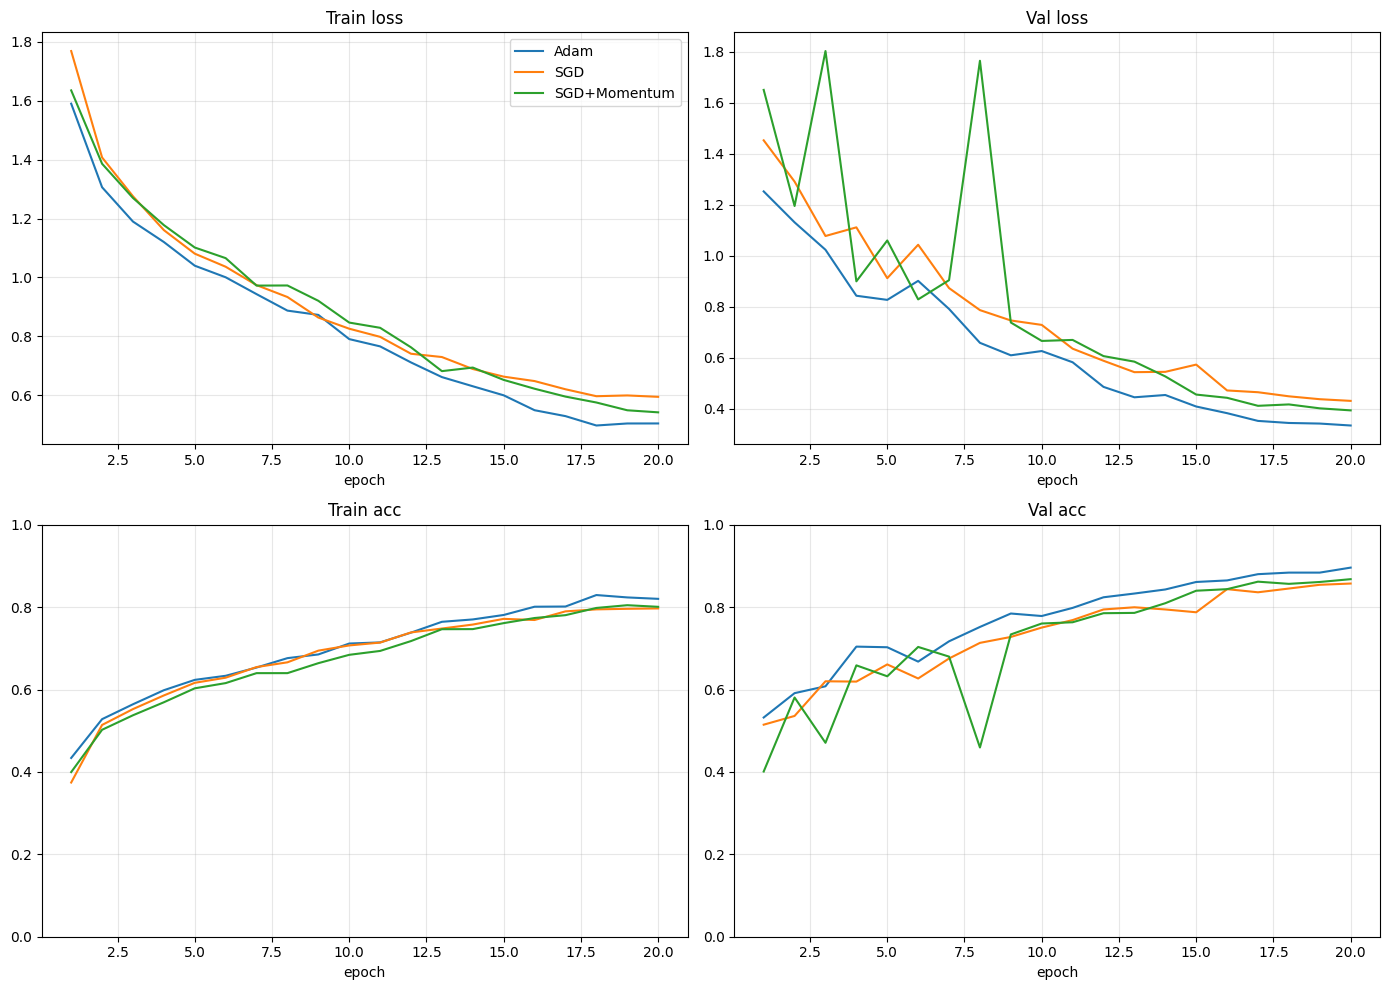

In [25]:
def plot_optimizer_comparison(histories, names, save_path=None):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    epochs = range(1, len(histories[0]['train_loss']) + 1)

    for h, n in zip(histories, names):
        axes[0, 0].plot(epochs, h['train_loss'], label=n)
    axes[0, 0].set_title('Train loss')

    for h, n in zip(histories, names):
        axes[0, 1].plot(epochs, h['val_loss'], label=n)
    axes[0, 1].set_title('Val loss')

    for h, n in zip(histories, names):
        axes[1, 0].plot(epochs, h['train_acc'], label=n)
    axes[1, 0].set_title('Train acc')
    axes[1, 0].set_ylim([0, 1])

    for h, n in zip(histories, names):
        axes[1, 1].plot(epochs, h['val_acc'], label=n)
    axes[1, 1].set_title('Val acc')
    axes[1, 1].set_ylim([0, 1])

    for ax in axes.ravel():
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('epoch')

    axes[0, 0].legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_optimizer_comparison(
    histories=[adam_history, sgd_history, sgd_momentum_history],
    names=['Adam', 'SGD', 'SGD+Momentum'],
    save_path=os.path.join(PART1_DIR, 'optimizer_comparison.png')
)

## 10) Test eval (all optimizers)

In [26]:
import time

print("="*80)
print("EVALUATING ALL OPTIMIZERS ON TEST SET")
print("="*80)

# Function to evaluate model on test set
def evaluate_on_test_set(model, test_loader, criterion, device, model_name):
    """Evaluate model on test set and return metrics"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time.time()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    inference_time = time.time() - start_time
    
    test_accuracy = correct / total
    avg_test_loss = test_loss / total
    
    print(f"\n{model_name}:")
    print(f"  Test Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"  Test Loss:         {avg_test_loss:.4f}")
    print(f"  Inference Time:    {inference_time:.2f}s")
    print(f"  Correct/Total:     {correct}/{total}")
    
    return test_accuracy, avg_test_loss, inference_time

# Define criterion for evaluation
criterion = nn.CrossEntropyLoss()

# Evaluate Adam Model
adam_test_acc, adam_test_loss, adam_inference_time = evaluate_on_test_set(
    model_adam, test_loader, criterion, DEVICE, "Adam Optimizer"
)

# Evaluate SGD Model
sgd_test_acc, sgd_test_loss, sgd_inference_time = evaluate_on_test_set(
    model_sgd, test_loader, criterion, DEVICE, "SGD Optimizer"
)

# Evaluate SGD with Momentum Model
sgd_mom_test_acc, sgd_mom_test_loss, sgd_mom_inference_time = evaluate_on_test_set(
    model_sgd_momentum, test_loader, criterion, DEVICE, "SGD with Momentum"
)

print("\n" + "="*80)
print("TEST SET EVALUATION COMPLETED")
print("="*80)

EVALUATING ALL OPTIMIZERS ON TEST SET

Adam Optimizer:
  Test Accuracy:     0.9006 (90.06%)
  Test Loss:         0.3216
  Inference Time:    9.05s
  Correct/Total:     1205/1338

SGD Optimizer:
  Test Accuracy:     0.8670 (86.70%)
  Test Loss:         0.4072
  Inference Time:    8.02s
  Correct/Total:     1160/1338

SGD with Momentum:
  Test Accuracy:     0.8916 (89.16%)
  Test Loss:         0.3623
  Inference Time:    7.57s
  Correct/Total:     1193/1338

TEST SET EVALUATION COMPLETED


### Metrics

In [27]:
# Collect comprehensive metrics for all three optimizers
optimizer_comparison = {
    'Adam': {
        'test_accuracy': adam_test_acc,
        'test_loss': adam_test_loss,
        'final_train_acc': adam_history['train_acc'][-1],
        'final_val_acc': adam_history['val_acc'][-1],
        'best_val_acc': max(adam_history['val_acc']),
        'final_train_loss': adam_history['train_loss'][-1],
        'final_val_loss': adam_history['val_loss'][-1],
        'epochs_trained': len(adam_history['train_acc']),
        'inference_time': adam_inference_time,
        'train_val_acc_gap': adam_history['train_acc'][-1] - adam_history['val_acc'][-1],
        'train_test_acc_gap': adam_history['train_acc'][-1] - adam_test_acc
    },
    'SGD': {
        'test_accuracy': sgd_test_acc,
        'test_loss': sgd_test_loss,
        'final_train_acc': sgd_history['train_acc'][-1],
        'final_val_acc': sgd_history['val_acc'][-1],
        'best_val_acc': max(sgd_history['val_acc']),
        'final_train_loss': sgd_history['train_loss'][-1],
        'final_val_loss': sgd_history['val_loss'][-1],
        'epochs_trained': len(sgd_history['train_acc']),
        'inference_time': sgd_inference_time,
        'train_val_acc_gap': sgd_history['train_acc'][-1] - sgd_history['val_acc'][-1],
        'train_test_acc_gap': sgd_history['train_acc'][-1] - sgd_test_acc
    },
    'SGD + Momentum': {
        'test_accuracy': sgd_mom_test_acc,
        'test_loss': sgd_mom_test_loss,
        'final_train_acc': sgd_momentum_history['train_acc'][-1],
        'final_val_acc': sgd_momentum_history['val_acc'][-1],
        'best_val_acc': max(sgd_momentum_history['val_acc']),
        'final_train_loss': sgd_momentum_history['train_loss'][-1],
        'final_val_loss': sgd_momentum_history['val_loss'][-1],
        'epochs_trained': len(sgd_momentum_history['train_acc']),
        'inference_time': sgd_mom_inference_time,
        'train_val_acc_gap': sgd_momentum_history['train_acc'][-1] - sgd_momentum_history['val_acc'][-1],
        'train_test_acc_gap': sgd_momentum_history['train_acc'][-1] - sgd_mom_test_acc
    }
}

print("\nMetrics collected successfully for all optimizers!")


Metrics collected successfully for all optimizers!


### Compare at a glance

In [28]:
print("== Optimizer comparison ==")
print(f"{'opt':<18} {'test_acc':<10} {'test_loss':<10} {'inference(s)':<12}")
for opt, m in optimizer_comparison.items():
    print(f"{opt:<18} {m['test_accuracy']:.4f} {m['test_loss']:.4f} {m['inference_time']:.2f}")

best_test_acc = max(optimizer_comparison.items(), key=lambda x: x[1]['test_accuracy'])
best_test_loss = min(optimizer_comparison.items(), key=lambda x: x[1]['test_loss'])
best_generalization = min(optimizer_comparison.items(), key=lambda x: x[1]['train_test_acc_gap'])
fastest_inference = min(optimizer_comparison.items(), key=lambda x: x[1]['inference_time'])

print("\nBest:")
print(f"acc -> {best_test_acc[0]} ({best_test_acc[1]['test_accuracy']*100:.2f}%)")
print(f"loss -> {best_test_loss[0]} ({best_test_loss[1]['test_loss']:.4f})")
print(f"gen  -> {best_generalization[0]} (gap {best_generalization[1]['train_test_acc_gap']:.4f})")
print(f"speed-> {fastest_inference[0]} ({fastest_inference[1]['inference_time']:.2f}s)")

== Optimizer comparison ==
opt                test_acc   test_loss  inference(s)
Adam               0.9006 0.3216 9.05
SGD                0.8670 0.4072 8.02
SGD + Momentum     0.8916 0.3623 7.57

Best:
acc -> Adam (90.06%)
loss -> Adam (0.3216)
gen  -> SGD + Momentum (gap -0.0907)
speed-> SGD + Momentum (7.57s)


Comprehensive comparison plot saved to results\part1\optimizer_comparison_comprehensive.png


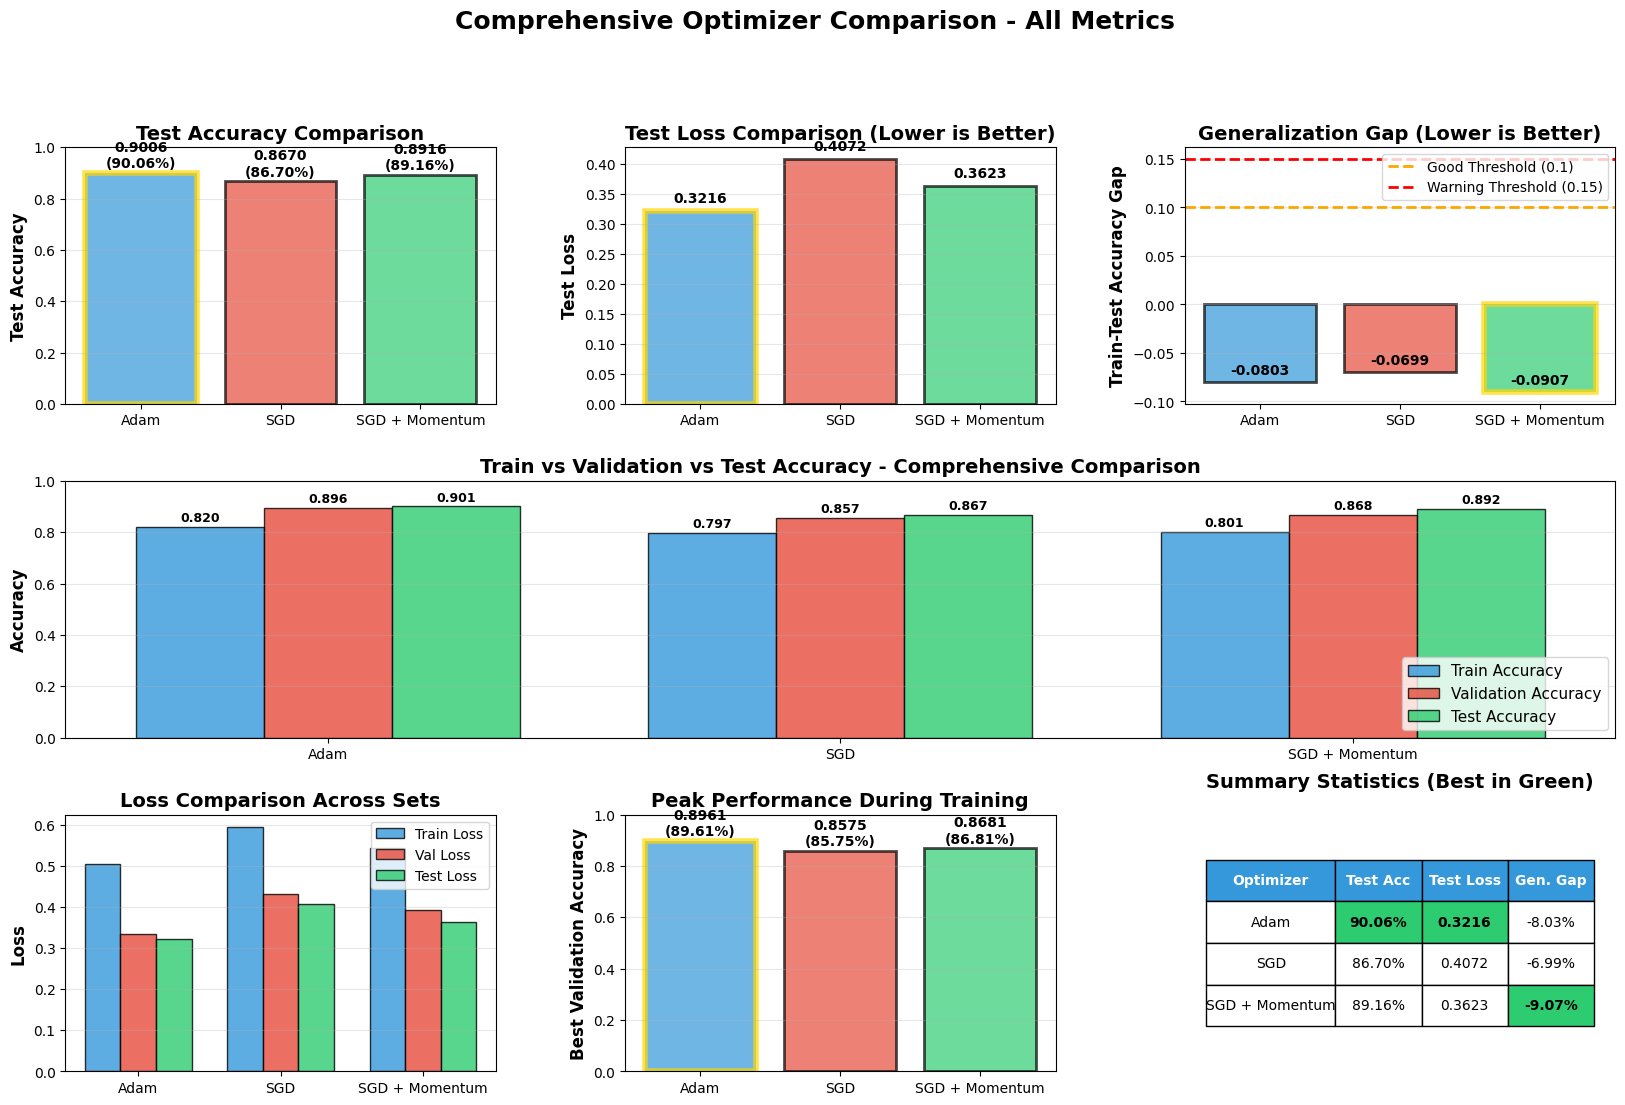

In [29]:
# Create comprehensive visual comparison
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

optimizers = list(optimizer_comparison.keys())
colors = ['#3498db', '#e74c3c', '#2ecc71']

# 1. Test Accuracy Comparison
ax1 = fig.add_subplot(gs[0, 0])
test_accs = [optimizer_comparison[opt]['test_accuracy'] for opt in optimizers]
bars = ax1.bar(optimizers, test_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for i, (bar, acc) in enumerate(zip(bars, test_accs)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}\n({acc*100:.2f}%)', ha='center', va='bottom', fontweight='bold')
# Highlight best
best_idx = test_accs.index(max(test_accs))
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)

# 2. Test Loss Comparison
ax2 = fig.add_subplot(gs[0, 1])
test_losses = [optimizer_comparison[opt]['test_loss'] for opt in optimizers]
bars = ax2.bar(optimizers, test_losses, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Test Loss', fontsize=12, fontweight='bold')
ax2.set_title('Test Loss Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, (bar, loss) in enumerate(zip(bars, test_losses)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{loss:.4f}', ha='center', va='bottom', fontweight='bold')
# Highlight best
best_idx = test_losses.index(min(test_losses))
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)

# 3. Generalization Gap Comparison
ax3 = fig.add_subplot(gs[0, 2])
train_test_gaps = [optimizer_comparison[opt]['train_test_acc_gap'] for opt in optimizers]
bars = ax3.bar(optimizers, train_test_gaps, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Train-Test Accuracy Gap', fontsize=12, fontweight='bold')
ax3.set_title('Generalization Gap (Lower is Better)', fontsize=14, fontweight='bold')
ax3.axhline(y=0.1, color='orange', linestyle='--', linewidth=2, label='Good Threshold (0.1)')
ax3.axhline(y=0.15, color='red', linestyle='--', linewidth=2, label='Warning Threshold (0.15)')
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='upper right')
for i, (bar, gap) in enumerate(zip(bars, train_test_gaps)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{gap:.4f}', ha='center', va='bottom', fontweight='bold')
# Highlight best
best_idx = train_test_gaps.index(min(train_test_gaps))
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)

# 4. Training vs Validation vs Test Accuracy
ax4 = fig.add_subplot(gs[1, :])
x = np.arange(len(optimizers))
width = 0.25
train_accs = [optimizer_comparison[opt]['final_train_acc'] for opt in optimizers]
val_accs = [optimizer_comparison[opt]['final_val_acc'] for opt in optimizers]

bars1 = ax4.bar(x - width, train_accs, width, label='Train Accuracy', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax4.bar(x, val_accs, width, label='Validation Accuracy', color='#e74c3c', alpha=0.8, edgecolor='black')
bars3 = ax4.bar(x + width, test_accs, width, label='Test Accuracy', color='#2ecc71', alpha=0.8, edgecolor='black')

ax4.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax4.set_title('Train vs Validation vs Test Accuracy - Comprehensive Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(optimizers)
ax4.legend(loc='lower right', fontsize=11)
ax4.set_ylim([0, 1])
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 5. Loss Comparison (Train vs Val vs Test)
ax5 = fig.add_subplot(gs[2, 0])
train_losses = [optimizer_comparison[opt]['final_train_loss'] for opt in optimizers]
val_losses = [optimizer_comparison[opt]['final_val_loss'] for opt in optimizers]

x_pos = np.arange(len(optimizers))
width = 0.25
ax5.bar(x_pos - width, train_losses, width, label='Train Loss', color='#3498db', alpha=0.8, edgecolor='black')
ax5.bar(x_pos, val_losses, width, label='Val Loss', color='#e74c3c', alpha=0.8, edgecolor='black')
ax5.bar(x_pos + width, test_losses, width, label='Test Loss', color='#2ecc71', alpha=0.8, edgecolor='black')
ax5.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax5.set_title('Loss Comparison Across Sets', fontsize=14, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(optimizers)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Best Validation Accuracy Achieved
ax6 = fig.add_subplot(gs[2, 1])
best_val_accs = [optimizer_comparison[opt]['best_val_acc'] for opt in optimizers]
bars = ax6.bar(optimizers, best_val_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax6.set_ylabel('Best Validation Accuracy', fontsize=12, fontweight='bold')
ax6.set_title('Peak Performance During Training', fontsize=14, fontweight='bold')
ax6.set_ylim([0, 1])
ax6.grid(axis='y', alpha=0.3)
for i, (bar, acc) in enumerate(zip(bars, best_val_accs)):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}\n({acc*100:.2f}%)', ha='center', va='bottom', fontweight='bold')
# Highlight best
best_idx = best_val_accs.index(max(best_val_accs))
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)

# 7. Summary Statistics Table
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')

summary_data = []
for opt in optimizers:
    metrics = optimizer_comparison[opt]
    summary_data.append([
        opt,
        f"{metrics['test_accuracy']*100:.2f}%",
        f"{metrics['test_loss']:.4f}",
        f"{metrics['train_test_acc_gap']*100:.2f}%"
    ])

table = ax7.table(cellText=summary_data,
                  colLabels=['Optimizer', 'Test Acc', 'Test Loss', 'Gen. Gap'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.3, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight best values
best_acc_idx = test_accs.index(max(test_accs)) + 1
best_loss_idx = test_losses.index(min(test_losses)) + 1
best_gap_idx = train_test_gaps.index(min(train_test_gaps)) + 1

table[(best_acc_idx, 1)].set_facecolor('#2ecc71')
table[(best_acc_idx, 1)].set_text_props(weight='bold')
table[(best_loss_idx, 2)].set_facecolor('#2ecc71')
table[(best_loss_idx, 2)].set_text_props(weight='bold')
table[(best_gap_idx, 3)].set_facecolor('#2ecc71')
table[(best_gap_idx, 3)].set_text_props(weight='bold')

ax7.set_title('Summary Statistics (Best in Green)', fontsize=14, fontweight='bold', pad=20)

plt.suptitle('Comprehensive Optimizer Comparison - All Metrics', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(os.path.join(PART1_DIR, 'optimizer_comparison_comprehensive.png'), dpi=300, bbox_inches='tight')
print(f"Comprehensive comparison plot saved to {os.path.join(PART1_DIR, 'optimizer_comparison_comprehensive.png')}")
plt.show()

In [30]:
adam_metrics = optimizer_comparison['Adam']
sgd_metrics = optimizer_comparison['SGD']
sgd_mom_metrics = optimizer_comparison['SGD + Momentum']

acc_ranking = sorted(optimizer_comparison.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)
gen_ranking = sorted(optimizer_comparison.items(), key=lambda x: x[1]['train_test_acc_gap'])
loss_ranking = sorted(optimizer_comparison.items(), key=lambda x: x[1]['test_loss'])

print("Ranking (higher is better unless noted)")
print("- acc:")
for i, (name, m) in enumerate(acc_ranking, 1):
    print(f"  {i}. {name} -> {m['test_accuracy']*100:.2f}%")
print("- gen (lower gap):")
for i, (name, m) in enumerate(gen_ranking, 1):
    print(f"  {i}. {name} -> gap {m['train_test_acc_gap']:.4f}")
print("- loss (lower):")
for i, (name, m) in enumerate(loss_ranking, 1):
    print(f"  {i}. {name} -> {m['test_loss']:.4f}")

Ranking (higher is better unless noted)
- acc:
  1. Adam -> 90.06%
  2. SGD + Momentum -> 89.16%
  3. SGD -> 86.70%
- gen (lower gap):
  1. SGD + Momentum -> gap -0.0907
  2. Adam -> gap -0.0803
  3. SGD -> gap -0.0699
- loss (lower):
  1. Adam -> 0.3216
  2. SGD + Momentum -> 0.3623
  3. SGD -> 0.4072


## 11) Adam training

Plot saved to results\part1\adam_training_analysis.png


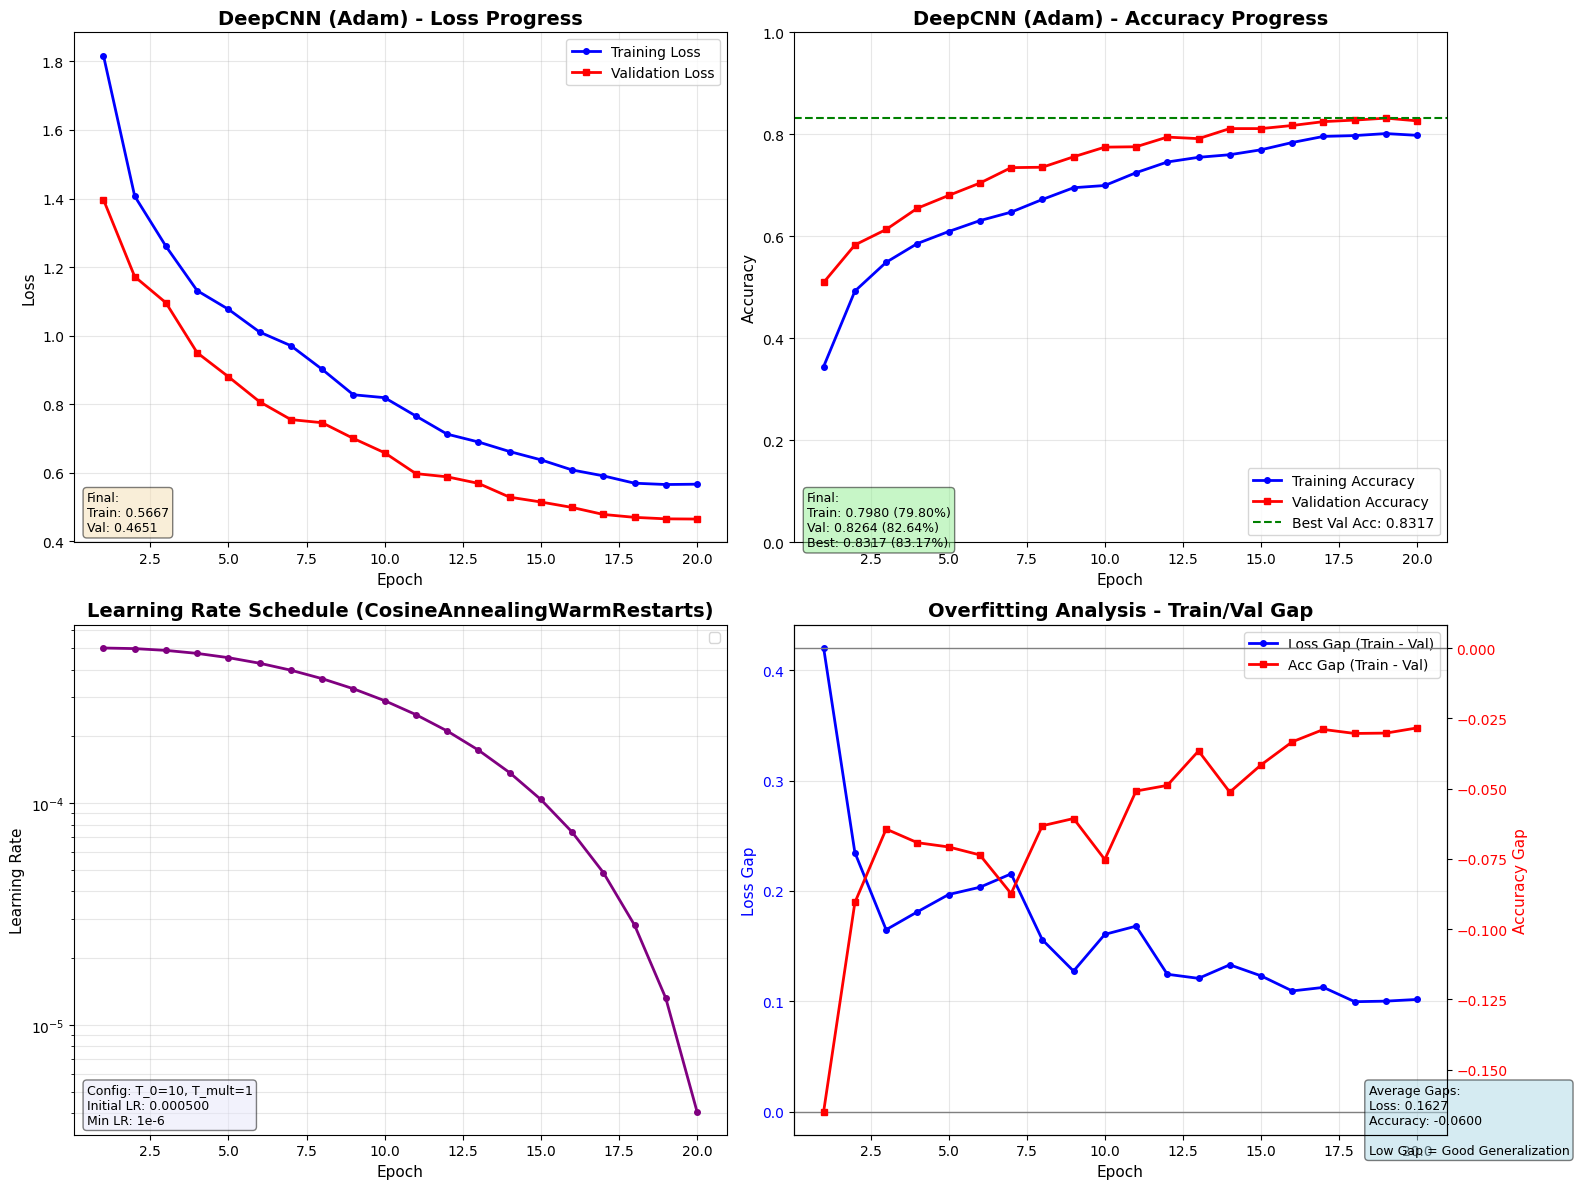

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs = range(1, len(adam_history['train_loss']) + 1)

# Loss Progress
axes[0, 0].plot(epochs, adam_history['train_loss'], '-o', label='Training Loss', linewidth=2, markersize=4, color='blue')
axes[0, 0].plot(epochs, adam_history['val_loss'], '-s', label='Validation Loss', linewidth=2, markersize=4, color='red')
axes[0, 0].set_title('DeepCNN (Adam) - Loss Progress', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].legend(loc='upper right')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.02, 0.10, f'Final:\nTrain: {adam_history["train_loss"][-1]:.4f}\nVal: {adam_history["val_loss"][-1]:.4f}',
                transform=axes[0, 0].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Accuracy Progress
axes[0, 1].plot(epochs, adam_history['train_acc'], '-o', label='Training Accuracy', linewidth=2, markersize=4, color='blue')
axes[0, 1].plot(epochs, adam_history['val_acc'], '-s', label='Validation Accuracy', linewidth=2, markersize=4, color='red')
axes[0, 1].axhline(y=max(adam_history['val_acc']), color='green', linestyle='--', linewidth=1.5, 
                   label=f'Best Val Acc: {max(adam_history["val_acc"]):.4f}')
axes[0, 1].set_title('DeepCNN (Adam) - Accuracy Progress', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])
axes[0, 1].text(0.02, 0.10, f'Final:\nTrain: {adam_history["train_acc"][-1]:.4f} ({adam_history["train_acc"][-1]*100:.2f}%)\nVal: {adam_history["val_acc"][-1]:.4f} ({adam_history["val_acc"][-1]*100:.2f}%)\nBest: {max(adam_history["val_acc"]):.4f} ({max(adam_history["val_acc"])*100:.2f}%)',
                transform=axes[0, 1].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Learning Rate Schedule
axes[1, 0].plot(epochs, adam_history['learning_rates'], '-o', linewidth=2, markersize=4, color='purple')
axes[1, 0].set_title('Learning Rate Schedule (CosineAnnealingWarmRestarts)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Learning Rate', fontsize=11)
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3, which='both')
axes[1, 0].legend()
axes[1, 0].text(0.02, 0.10, f'Config: T_0=10, T_mult=1\nInitial LR: {adam_history["learning_rates"][0]:.6f}\nMin LR: 1e-6',
                transform=axes[1, 0].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.5))

# Overfitting Analysis - Train/Val Gap
loss_gap = [train - val for train, val in zip(adam_history['train_loss'], adam_history['val_loss'])]
acc_gap = [train - val for train, val in zip(adam_history['train_acc'], adam_history['val_acc'])]

ax_gap = axes[1, 1]
ax_gap.plot(epochs, loss_gap, '-o', label='Loss Gap (Train - Val)', linewidth=2, markersize=4, color='blue')
ax_gap.set_xlabel('Epoch', fontsize=11)
ax_gap.set_ylabel('Loss Gap', fontsize=11, color='blue')
ax_gap.tick_params(axis='y', labelcolor='blue')
ax_gap.grid(True, alpha=0.3)
ax_gap.axhline(y=0, color='gray', linestyle='-', linewidth=1)

ax_gap2 = ax_gap.twinx()
ax_gap2.plot(epochs, acc_gap, '-s', label='Acc Gap (Train - Val)', linewidth=2, markersize=4, color='red')
ax_gap2.set_ylabel('Accuracy Gap', fontsize=11, color='red')
ax_gap2.tick_params(axis='y', labelcolor='red')
ax_gap2.axhline(y=0, color='gray', linestyle='-', linewidth=1)

axes[1, 1].set_title('Overfitting Analysis - Train/Val Gap', fontsize=14, fontweight='bold')
avg_loss_gap = np.mean(loss_gap)
avg_acc_gap = np.mean(acc_gap)
axes[1, 1].text(0.88, 0.10, f'Average Gaps:\nLoss: {avg_loss_gap:.4f}\nAccuracy: {avg_acc_gap:.4f}\n\nLow Gap = Good Generalization',
                transform=axes[1, 1].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

lines1, labels1 = ax_gap.get_legend_handles_labels()
lines2, labels2 = ax_gap2.get_legend_handles_labels()
ax_gap.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(PART1_DIR, 'adam_training_analysis.png'), dpi=300, bbox_inches='tight')
print(f"Plot saved to {os.path.join(PART1_DIR, 'adam_training_analysis.png')}")
plt.show()

## 12) Test eval (best Adam)

In [31]:
import torch
import numpy as np
import os
import time

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    preds, labels_all = [], []
    total = len(test_loader.dataset)

    start = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, p = torch.max(outputs, 1)
            preds.extend(p.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    test_loss /= total
    test_acc = np.mean(np.array(preds) == np.array(labels_all))

    print(f"test loss: {test_loss:.4f} | test acc: {test_acc:.4f} ({test_acc*100:.2f}%)")
    return test_loss, test_acc, preds, labels_all


# Load and evaluate the best model
best_model_path = os.path.join(MODELS_DIR, 'best_model_WasteCustom_Adam.pth')
print(f"loading: {best_model_path}")

best_model = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
best_model.load_state_dict(torch.load(best_model_path))

test_loss, test_acc, predictions, true_labels = evaluate_model(best_model, test_loader, criterion, DEVICE)

correct = np.sum(np.array(predictions) == np.array(true_labels))
incorrect = len(true_labels) - correct
print(f"samples: {len(true_labels)} | correct: {correct} | wrong: {incorrect}")

loading: results\models\best_model_WasteCustom_Adam.pth
test loss: 0.3216 | test acc: 0.9006 (90.06%)
samples: 1338 | correct: 1205 | wrong: 133


## 13) Confusion matrix

Confusion matrix saved to results\part1\confusion_matrix_adam.png


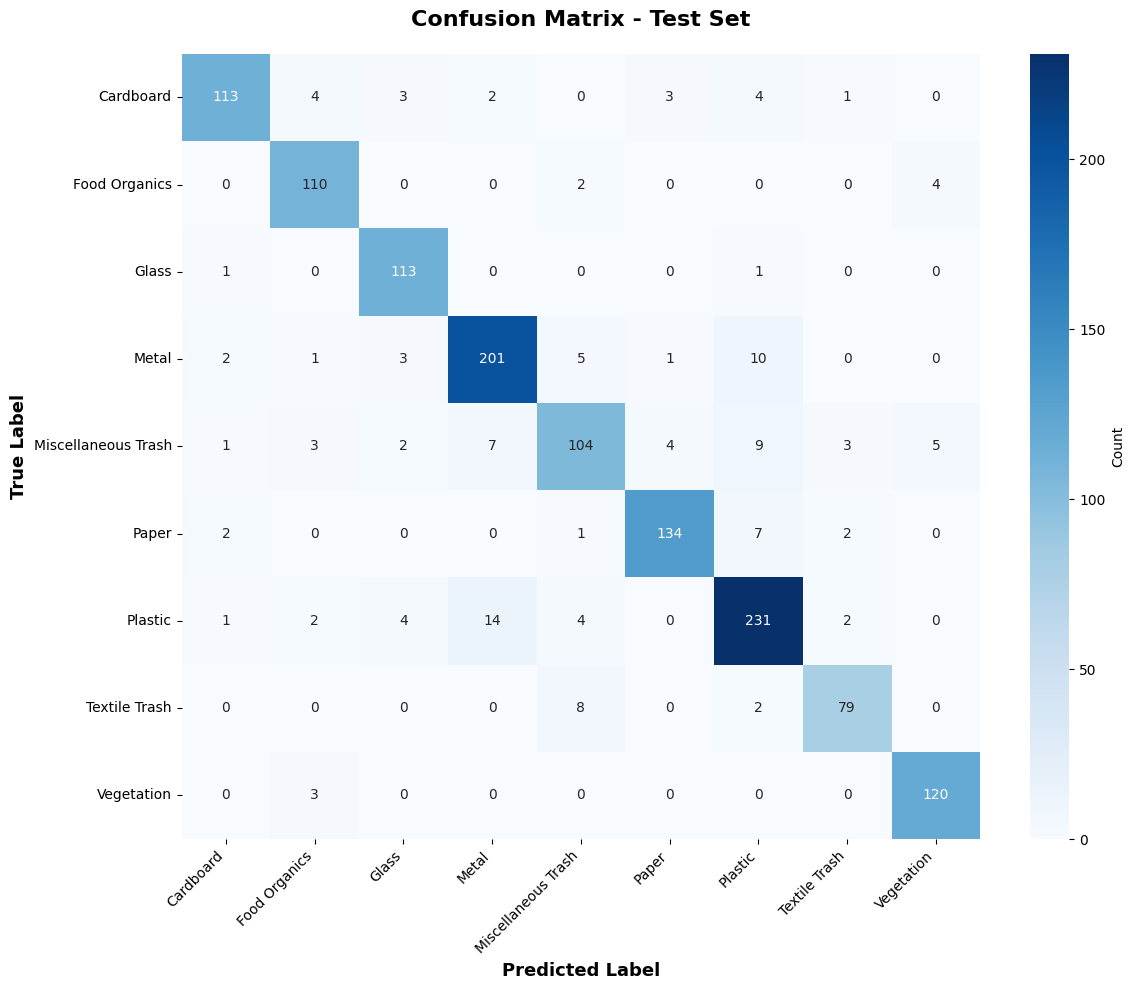

CONFUSION MATRIX ANALYSIS
Cardboard                : 113/130 correct (86.92%)
Food Organics            : 110/116 correct (94.83%)
Glass                    : 113/115 correct (98.26%)
Metal                    : 201/223 correct (90.13%)
Miscellaneous Trash      : 104/138 correct (75.36%)
Paper                    : 134/146 correct (91.78%)
Plastic                  : 231/258 correct (89.53%)
Textile Trash            :  79/ 89 correct (88.76%)
Vegetation               : 120/123 correct (97.56%)


In [32]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(PART1_DIR, 'confusion_matrix_adam.png'), dpi=300, bbox_inches='tight')
print(f"Confusion matrix saved to {os.path.join(PART1_DIR, 'confusion_matrix_adam.png')}")
plt.show()


print('CONFUSION MATRIX ANALYSIS')

for i, cls in enumerate(class_names):
    total = cm[i].sum()
    correct = cm[i, i]
    accuracy = correct / total if total > 0 else 0
    print(f'{cls:25s}: {correct:3d}/{total:3d} correct ({accuracy*100:5.2f}%)')

## 14) Classification report

In [33]:
print('='*70)
print('CLASSIFICATION REPORT')
print('='*70)
print(classification_report(true_labels, predictions, target_names=class_names, digits=4))

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(true_labels, predictions, average=None)

metrics_df = {
    'Class': class_names,
    'Precision': [f'{p:.4f}' for p in precision],
    'Recall': [f'{r:.4f}' for r in recall],
    'F1-Score': [f'{f:.4f}' for f in f1],
    'Support': support
}

print('\n' + '='*70)
print('PER-CLASS METRICS SUMMARY')
print('='*70)
for i in range(len(class_names)):
    print(f'{metrics_df["Class"][i]:25s} | P: {metrics_df["Precision"][i]} | R: {metrics_df["Recall"][i]} | F1: {metrics_df["F1-Score"][i]} | Support: {metrics_df["Support"][i]:3d}')
print('='*70)

CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          Cardboard     0.9417    0.8692    0.9040       130
      Food Organics     0.8943    0.9483    0.9205       116
              Glass     0.9040    0.9826    0.9417       115
              Metal     0.8973    0.9013    0.8993       223
Miscellaneous Trash     0.8387    0.7536    0.7939       138
              Paper     0.9437    0.9178    0.9306       146
            Plastic     0.8750    0.8953    0.8851       258
      Textile Trash     0.9080    0.8876    0.8977        89
         Vegetation     0.9302    0.9756    0.9524       123

           accuracy                         0.9006      1338
          macro avg     0.9037    0.9035    0.9028      1338
       weighted avg     0.9004    0.9006    0.8998      1338


PER-CLASS METRICS SUMMARY
Cardboard                 | P: 0.9417 | R: 0.8692 | F1: 0.9040 | Support: 130
Food Organics             | P: 0.8943 | R: 0.9483 | F1: 0.9205 | Support: 116

## 15) Per-class metrics

Performance metrics plot saved to results\part1\performance_metrics.png


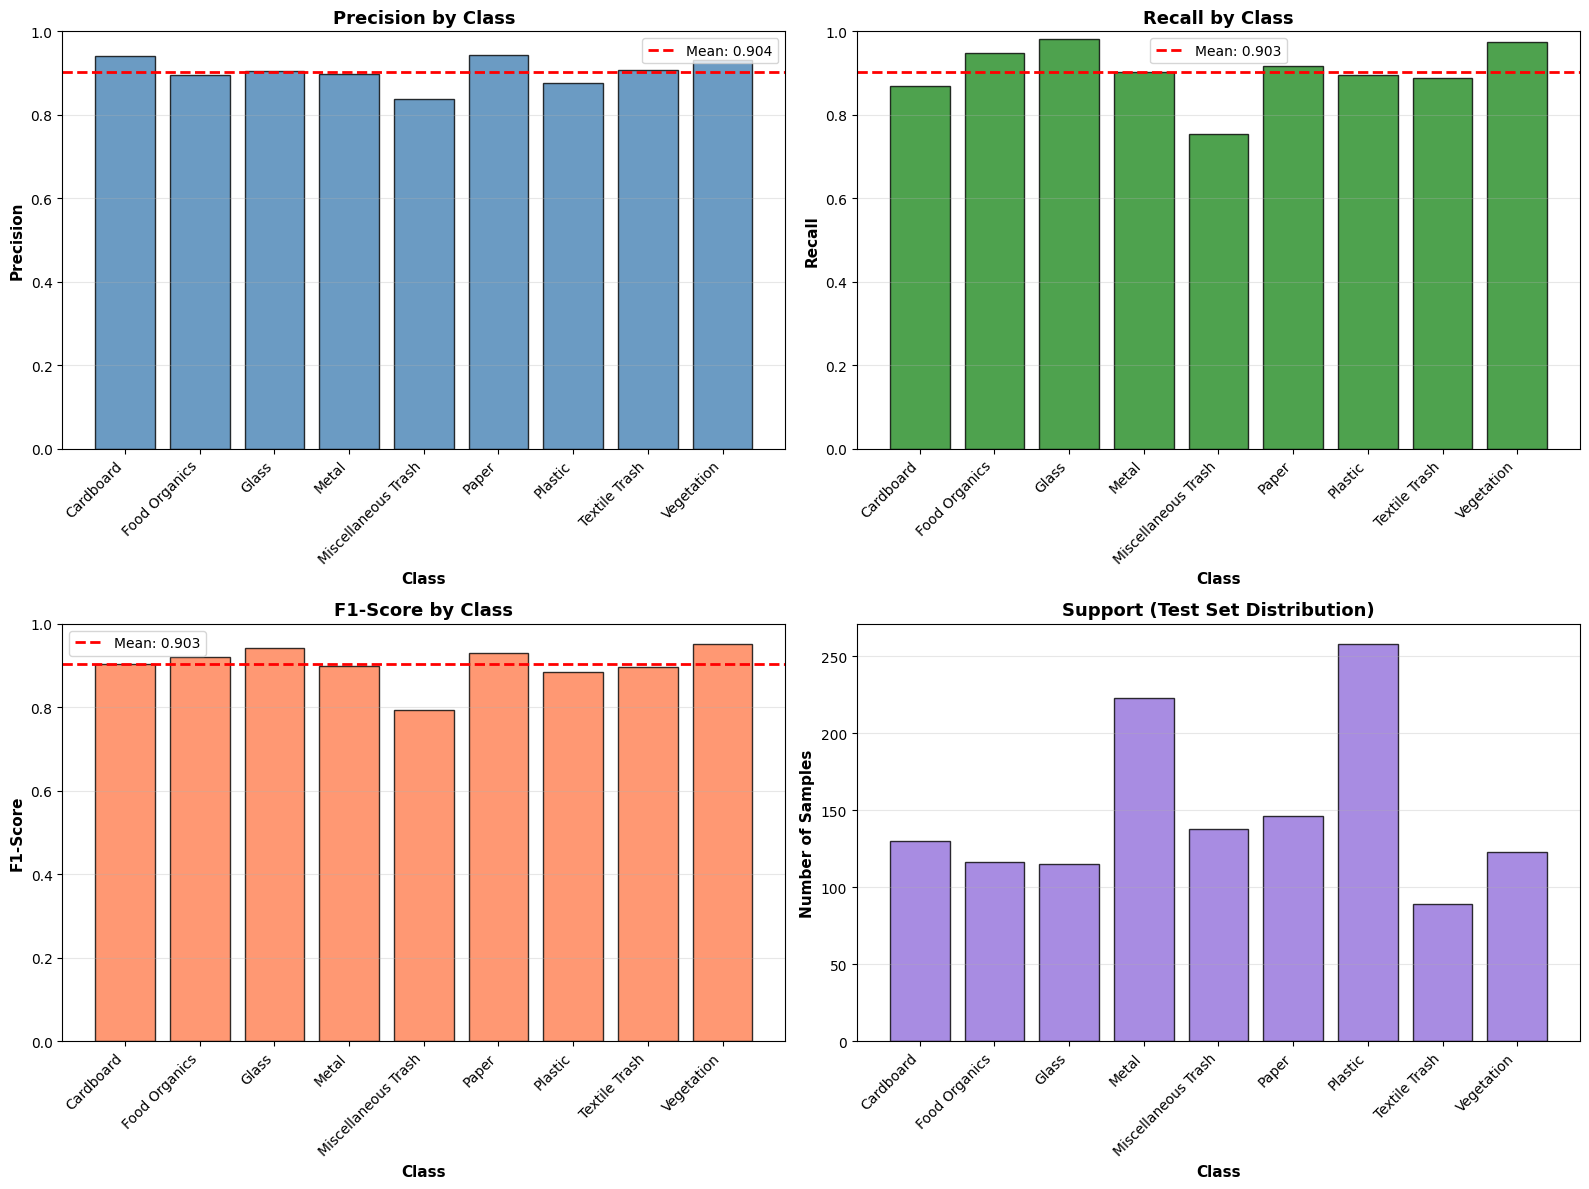

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

x_pos = np.arange(len(class_names))

# Precision
axes[0, 0].bar(x_pos, precision, color='steelblue', alpha=0.8, edgecolor='black')
axes[0, 0].set_xlabel('Class', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Precision', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Precision by Class', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axhline(y=np.mean(precision), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(precision):.3f}')
axes[0, 0].legend()

# Recall
axes[0, 1].bar(x_pos, recall, color='forestgreen', alpha=0.8, edgecolor='black')
axes[0, 1].set_xlabel('Class', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Recall', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Recall by Class', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(class_names, rotation=45, ha='right')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].axhline(y=np.mean(recall), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(recall):.3f}')
axes[0, 1].legend()

# F1-Score
axes[1, 0].bar(x_pos, f1, color='coral', alpha=0.8, edgecolor='black')
axes[1, 0].set_xlabel('Class', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('F1-Score', fontsize=11, fontweight='bold')
axes[1, 0].set_title('F1-Score by Class', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(class_names, rotation=45, ha='right')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].axhline(y=np.mean(f1), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(f1):.3f}')
axes[1, 0].legend()

# Support (Test Set Distribution)
axes[1, 1].bar(x_pos, support, color='mediumpurple', alpha=0.8, edgecolor='black')
axes[1, 1].set_xlabel('Class', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Support (Test Set Distribution)', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PART1_DIR, 'performance_metrics.png'), dpi=300, bbox_inches='tight')
print(f"Performance metrics plot saved to {os.path.join(PART1_DIR, 'performance_metrics.png')}")
plt.show()

In [35]:
print('== Adam model (test) ==')
print(f'acc: {test_acc:.4f} | loss: {test_loss:.4f}')
print('top-3 classes by F1:')
best_f1_idx = np.argsort(f1)[-3:][::-1]
for idx in best_f1_idx:
    print(f'  {class_names[idx]} -> F1 {f1[idx]:.4f} (P {precision[idx]:.4f}, R {recall[idx]:.4f})')

print('bottom-3 classes by F1:')
worst_f1_idx = np.argsort(f1)[:3]
for idx in worst_f1_idx:
    print(f'  {class_names[idx]} -> F1 {f1[idx]:.4f} (P {precision[idx]:.4f}, R {recall[idx]:.4f})')

# common confusions (top-5)
misclassifications = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            misclassifications.append((class_names[i], class_names[j], cm[i, j]))
misclassifications.sort(key=lambda x: x[2], reverse=True)
print('top-5 confusions:')
for true_cls, pred_cls, count in misclassifications[:5]:
    print(f'  {true_cls} -> {pred_cls}: {count}')

== Adam model (test) ==
acc: 0.9006 | loss: 0.3216
top-3 classes by F1:
  Vegetation -> F1 0.9524 (P 0.9302, R 0.9756)
  Glass -> F1 0.9417 (P 0.9040, R 0.9826)
  Paper -> F1 0.9306 (P 0.9437, R 0.9178)
bottom-3 classes by F1:
  Miscellaneous Trash -> F1 0.7939 (P 0.8387, R 0.7536)
  Plastic -> F1 0.8851 (P 0.8750, R 0.8953)
  Textile Trash -> F1 0.8977 (P 0.9080, R 0.8876)
top-5 confusions:
  Plastic -> Metal: 14
  Metal -> Plastic: 10
  Miscellaneous Trash -> Plastic: 9
  Textile Trash -> Miscellaneous Trash: 8
  Miscellaneous Trash -> Metal: 7


## 17) Sample predictions

Sample predictions saved to results\part1\sample_predictions.png


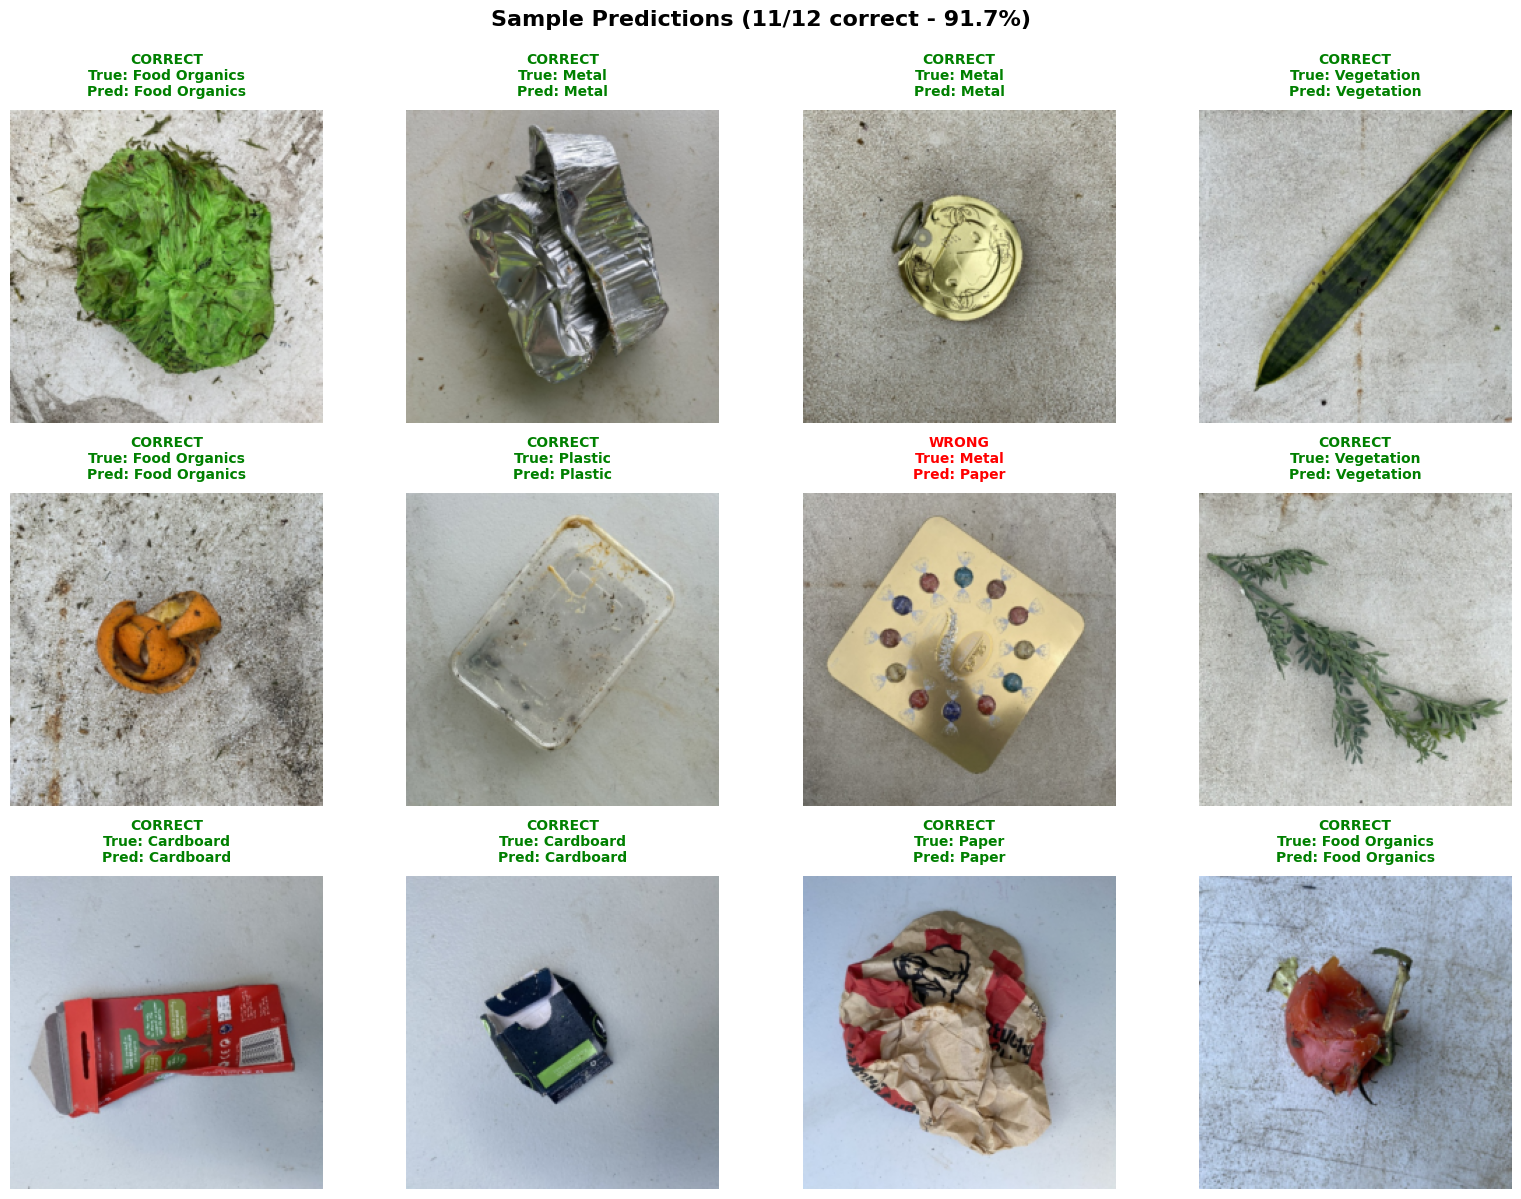

In [37]:
import random

def denormalize(tensor):
    """Denormalize image tensor for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

def show_predictions(model, test_dataset, class_names, device, num_samples=12):
    model.eval()
    indices = random.sample(range(len(test_dataset)), num_samples)

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    correct_count = 0

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = test_dataset[idx]
            image_input = image.unsqueeze(0).to(device)

            output = model(image_input)
            _, predicted = torch.max(output, 1)
            pred_label = predicted.item()

            img_display = denormalize(image).permute(1, 2, 0).cpu().numpy()

            axes[i].imshow(img_display)
            axes[i].axis('off')

            is_correct = (pred_label == true_label)
            if is_correct:
                correct_count += 1
                color = 'green'
                status = 'CORRECT'
            else:
                color = 'red'
                status = 'WRONG'

            axes[i].set_title(f'{status}\nTrue: {class_names[true_label]}\nPred: {class_names[pred_label]}', 
                            color=color, fontsize=10, fontweight='bold', pad=10)

    plt.suptitle(f'Sample Predictions ({correct_count}/{num_samples} correct - {correct_count/num_samples*100:.1f}%)',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(os.path.join(PART1_DIR, 'sample_predictions.png'), dpi=300, bbox_inches='tight')
    print(f"Sample predictions saved to {os.path.join(PART1_DIR, 'sample_predictions.png')}")
    plt.show()

# Get the test dataset (without DataLoader)
from torchvision import datasets, transforms
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(
    root=os.path.join(SPLIT_DATA_DIR, 'test'),
    transform=test_transform
)

show_predictions(best_model, test_dataset, class_names, DEVICE, num_samples=12)

# Part 2 — Transfer learning
ResNet-50 and EfficientNet-B0, fine-tuned on the same data. Compare against the custom CNN.

## 18) Install deps

In [43]:
# Install timm (PyTorch Image Models) for EfficientNet
! pip install timm -q

## 19) Helpers (TL)

In [43]:
import timm
from torchvision import models

PART2_DIR = os.path.join(RESULTS_DIR, 'part2')
os.makedirs(PART2_DIR, exist_ok=True)


def train_one_epoch_optimized(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / total, correct / total


def validate_optimized(model, val_loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / total, correct / total


def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer,
                               scheduler, device, num_epochs, patience=3, min_delta=0.001,
                               model_name='model'):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
    best_val_loss, best_wts, wait = float('inf'), None, 0
    print(f"training {model_name}...")
    for epoch in range(num_epochs):
        tr_loss, tr_acc = train_one_epoch_optimized(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_optimized(model, val_loader, criterion, device)
        if scheduler is not None:
            scheduler.step()
        lr = optimizer.param_groups[0]['lr']
        history['train_loss'].append(tr_loss); history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        history['lr'].append(lr)
        print(f"epoch {epoch+1:02d}/{num_epochs} | lr {lr:.6f} | train {tr_loss:.4f}/{tr_acc:.4f} | val {val_loss:.4f}/{val_acc:.4f}")
        if val_loss < best_val_loss - min_delta:
            best_val_loss, best_wts, wait = val_loss, model.state_dict().copy(), 0
            print("  -> new best")
        else:
            wait += 1
            if wait >= patience:
                print("early stop")
                break
    if best_wts is not None:
        model.load_state_dict(best_wts)
    print(f"best val loss: {best_val_loss:.4f}")
    return model, history

print("helpers ready")

helpers ready


## 20) ResNet-50 (transfer learning)

In [44]:
print("init ResNet-50")

resnet50 = models.resnet50(pretrained=True)

for p in resnet50.conv1.parameters(): p.requires_grad = False
for p in resnet50.bn1.parameters(): p.requires_grad = False
for p in resnet50.layer1.parameters(): p.requires_grad = False
for p in resnet50.layer2.parameters(): p.requires_grad = False

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, NUM_CLASSES)
)
resnet50 = resnet50.to(DEVICE)

total_params = sum(p.numel() for p in resnet50.parameters())
trainable_params = sum(p.numel() for p in resnet50.parameters() if p.requires_grad)
print(f"params: total {total_params:,} | trainable {trainable_params:,}")

criterion_resnet = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_resnet = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, resnet50.parameters()),
    lr=1e-4,
    weight_decay=0.05
)
scheduler_resnet = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=10, eta_min=1e-6)

resnet50, resnet_history = train_with_early_stopping(
    model=resnet50,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_resnet,
    optimizer=optimizer_resnet,
    scheduler=scheduler_resnet,
    device=DEVICE,
    num_epochs=10,
    patience=3,
    min_delta=0.001,
    model_name='ResNet-50'
)

resnet_model_path = os.path.join(MODELS_DIR, 'best_model_ResNet50_Adam.pth')
torch.save(resnet50.state_dict(), resnet_model_path)
print(f"saved -> {resnet_model_path}")

init ResNet-50
params: total 23,526,473 | trainable 22,081,545
training ResNet-50...
epoch 01/10 | lr 0.000098 | train 1.1626/0.7093 | val 0.8176/0.8749
  -> new best
epoch 02/10 | lr 0.000091 | train 0.7768/0.8938 | val 0.6488/0.9553
  -> new best
epoch 03/10 | lr 0.000080 | train 0.6421/0.9539 | val 0.5900/0.9757
  -> new best
epoch 04/10 | lr 0.000066 | train 0.6039/0.9684 | val 0.5671/0.9818
  -> new best
epoch 05/10 | lr 0.000051 | train 0.5637/0.9899 | val 0.5501/0.9871
  -> new best
epoch 06/10 | lr 0.000035 | train 0.5517/0.9915 | val 0.5388/0.9909
  -> new best
epoch 07/10 | lr 0.000021 | train 0.5358/0.9972 | val 0.5309/0.9924
  -> new best
epoch 08/10 | lr 0.000010 | train 0.5316/0.9972 | val 0.5285/0.9894
  -> new best
epoch 09/10 | lr 0.000003 | train 0.5258/0.9993 | val 0.5263/0.9932
  -> new best
epoch 10/10 | lr 0.000001 | train 0.5257/0.9984 | val 0.5252/0.9917
  -> new best
best val loss: 0.5252
saved -> results\models\best_model_ResNet50_Adam.pth


### ResNet-50 training

✓ ResNet-50 training analysis saved to results\part2/resnet50_training_analysis.png


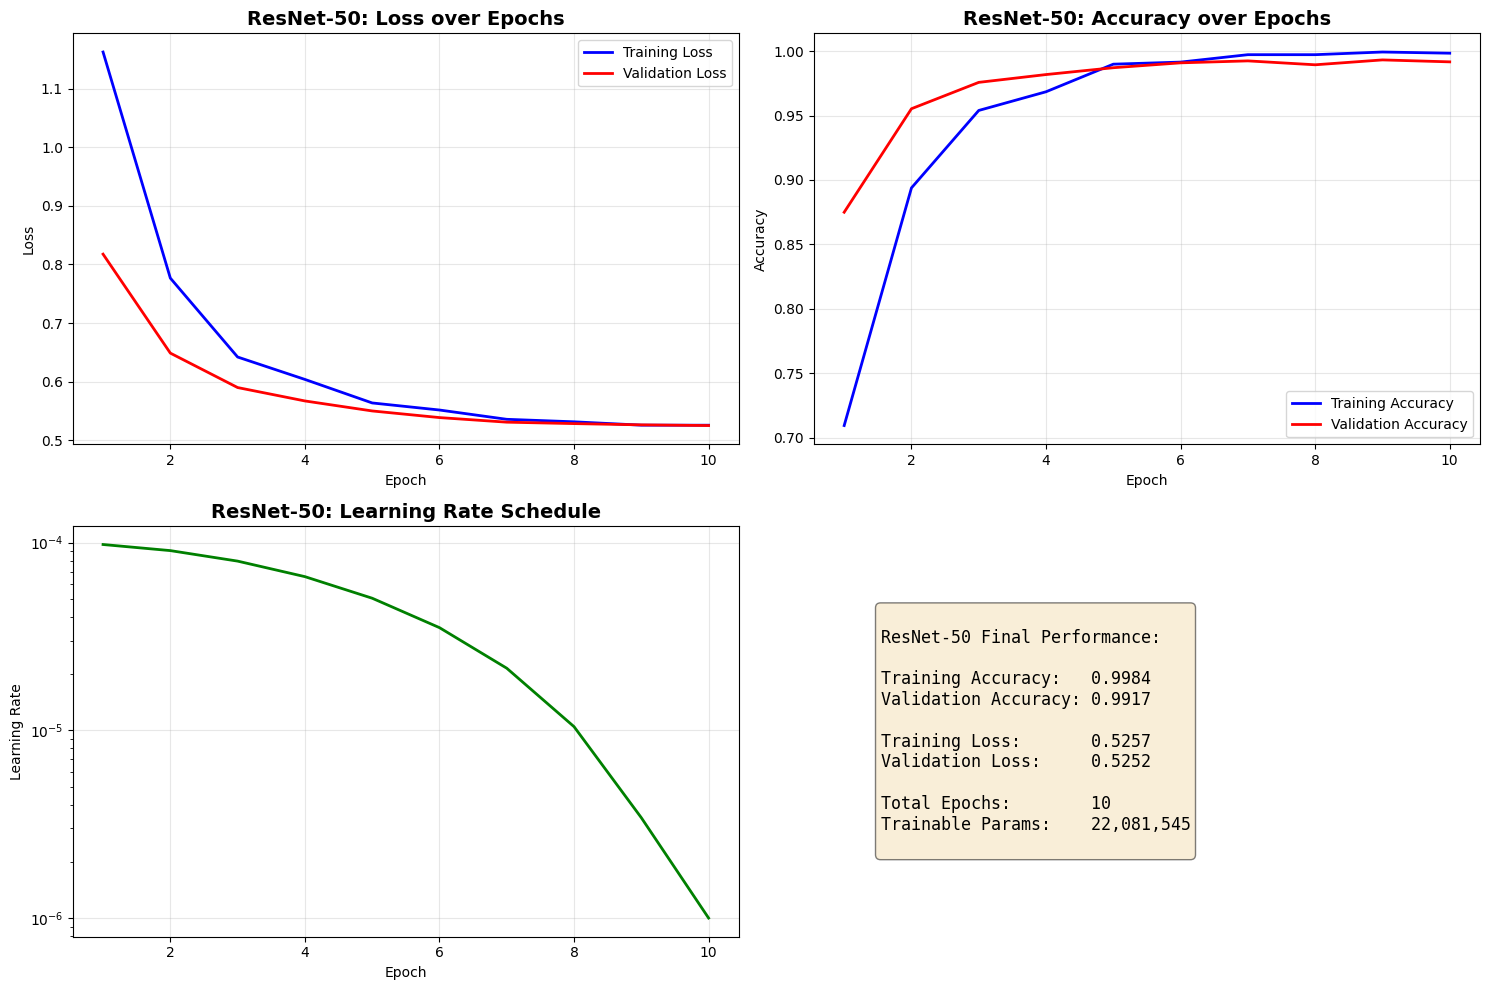

In [49]:
# Plot ResNet-50 training results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs_resnet = range(1, len(resnet_history['train_loss']) + 1)

# Training Loss
axes[0, 0].plot(epochs_resnet, resnet_history['train_loss'], 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs_resnet, resnet_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].set_title('ResNet-50: Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Training Accuracy
axes[0, 1].plot(epochs_resnet, resnet_history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
axes[0, 1].plot(epochs_resnet, resnet_history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('ResNet-50: Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning Rate
axes[1, 0].plot(epochs_resnet, resnet_history['lr'], 'g-', linewidth=2)
axes[1, 0].set_title('ResNet-50: Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Performance Summary
final_train_acc = resnet_history['train_acc'][-1]
final_val_acc = resnet_history['val_acc'][-1]
final_train_loss = resnet_history['train_loss'][-1]
final_val_loss = resnet_history['val_loss'][-1]

summary_text = f"""
ResNet-50 Final Performance:

Training Accuracy:   {final_train_acc:.4f}
Validation Accuracy: {final_val_acc:.4f}

Training Loss:       {final_train_loss:.4f}
Validation Loss:     {final_val_loss:.4f}

Total Epochs:        {len(epochs_resnet)}
Trainable Params:    {trainable_params:,}
"""

axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(PART2_DIR, 'resnet50_training_analysis.png'), dpi=300, bbox_inches='tight')
print(f"✓ ResNet-50 training analysis saved to {PART2_DIR}/resnet50_training_analysis.png")
plt.show()

## 21) EfficientNet-B0 (transfer learning)

In [50]:
# EfficientNet-B0 uses 224x224; add slightly stronger aug
print("setup loaders for EfficientNet-B0")

efficientnet_train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

efficientnet_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

efficientnet_train_dataset = datasets.ImageFolder(
    root=os.path.join(SPLIT_DATA_DIR, 'train'),
    transform=efficientnet_train_transform
)

efficientnet_val_dataset = datasets.ImageFolder(
    root=os.path.join(SPLIT_DATA_DIR, 'validation'),
    transform=efficientnet_val_transform
)

efficientnet_train_loader = DataLoader(
    efficientnet_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

efficientnet_val_loader = DataLoader(
    efficientnet_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"train {len(efficientnet_train_dataset):,} | val {len(efficientnet_val_dataset):,}")

setup loaders for EfficientNet-B0
train 4,341 | val 1,319


In [41]:
print("init EfficientNet-B0")

efficientnet_b0 = timm.create_model('efficientnet_b0', pretrained=True, num_classes=NUM_CLASSES)

for name, param in efficientnet_b0.named_parameters():
    if any(k in name for k in ['blocks.0', 'blocks.1', 'blocks.2', 'blocks.3', 'conv_stem', 'bn1']):
        param.requires_grad = False

efficientnet_b0 = efficientnet_b0.to(DEVICE)

total_params_eff = sum(p.numel() for p in efficientnet_b0.parameters())
trainable_params_eff = sum(p.numel() for p in efficientnet_b0.parameters() if p.requires_grad)
print(f"params: total {total_params_eff:,} | trainable {trainable_params_eff:,} | vs resnet {total_params/1e6:.2f}M")

criterion_eff = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_eff = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, efficientnet_b0.parameters()),
    lr=5e-4,
    weight_decay=0.05
)
scheduler_eff = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_eff, T_max=10, eta_min=1e-6)

efficientnet_b0, efficientnet_history = train_with_early_stopping(
    model=efficientnet_b0,
    train_loader=efficientnet_train_loader,
    val_loader=efficientnet_val_loader,
    criterion=criterion_eff,
    optimizer=optimizer_eff,
    scheduler=scheduler_eff,
    device=DEVICE,
    num_epochs=10,
    patience=3,
    min_delta=0.001,
    model_name='EfficientNet-B0'
)

efficientnet_model_path = os.path.join(MODELS_DIR, 'best_model_EfficientNetB0_Adam.pth')
torch.save(efficientnet_b0.state_dict(), efficientnet_model_path)
print(f"saved -> {efficientnet_model_path}")

init EfficientNet-B0
params: total 4,019,077 | trainable 3,696,209 | vs resnet 8.91M
training EfficientNet-B0...
epoch 01/10 | lr 0.000488 | train 1.4757/0.6522 | val 0.9236/0.8597
  -> new best
epoch 02/10 | lr 0.000452 | train 0.8979/0.8457 | val 0.7627/0.9151
  -> new best
epoch 03/10 | lr 0.000397 | train 0.7768/0.9014 | val 0.6712/0.9545
  -> new best
epoch 04/10 | lr 0.000328 | train 0.6949/0.9367 | val 0.6515/0.9560
  -> new best
epoch 05/10 | lr 0.000251 | train 0.6456/0.9597 | val 0.6072/0.9780
  -> new best
epoch 06/10 | lr 0.000173 | train 0.6105/0.9758 | val 0.5945/0.9803
  -> new best
epoch 07/10 | lr 0.000104 | train 0.5912/0.9800 | val 0.5829/0.9803
  -> new best
epoch 08/10 | lr 0.000049 | train 0.5800/0.9830 | val 0.5787/0.9841
  -> new best
epoch 09/10 | lr 0.000013 | train 0.5718/0.9871 | val 0.5756/0.9841
  -> new best
epoch 10/10 | lr 0.000001 | train 0.5659/0.9896 | val 0.5701/0.9841
  -> new best
best val loss: 0.5701
saved -> results\models\best_model_EfficientN

### EfficientNet-B0 training

✓ EfficientNet-B0 training analysis saved to results\part2/efficientnet_training_analysis.png


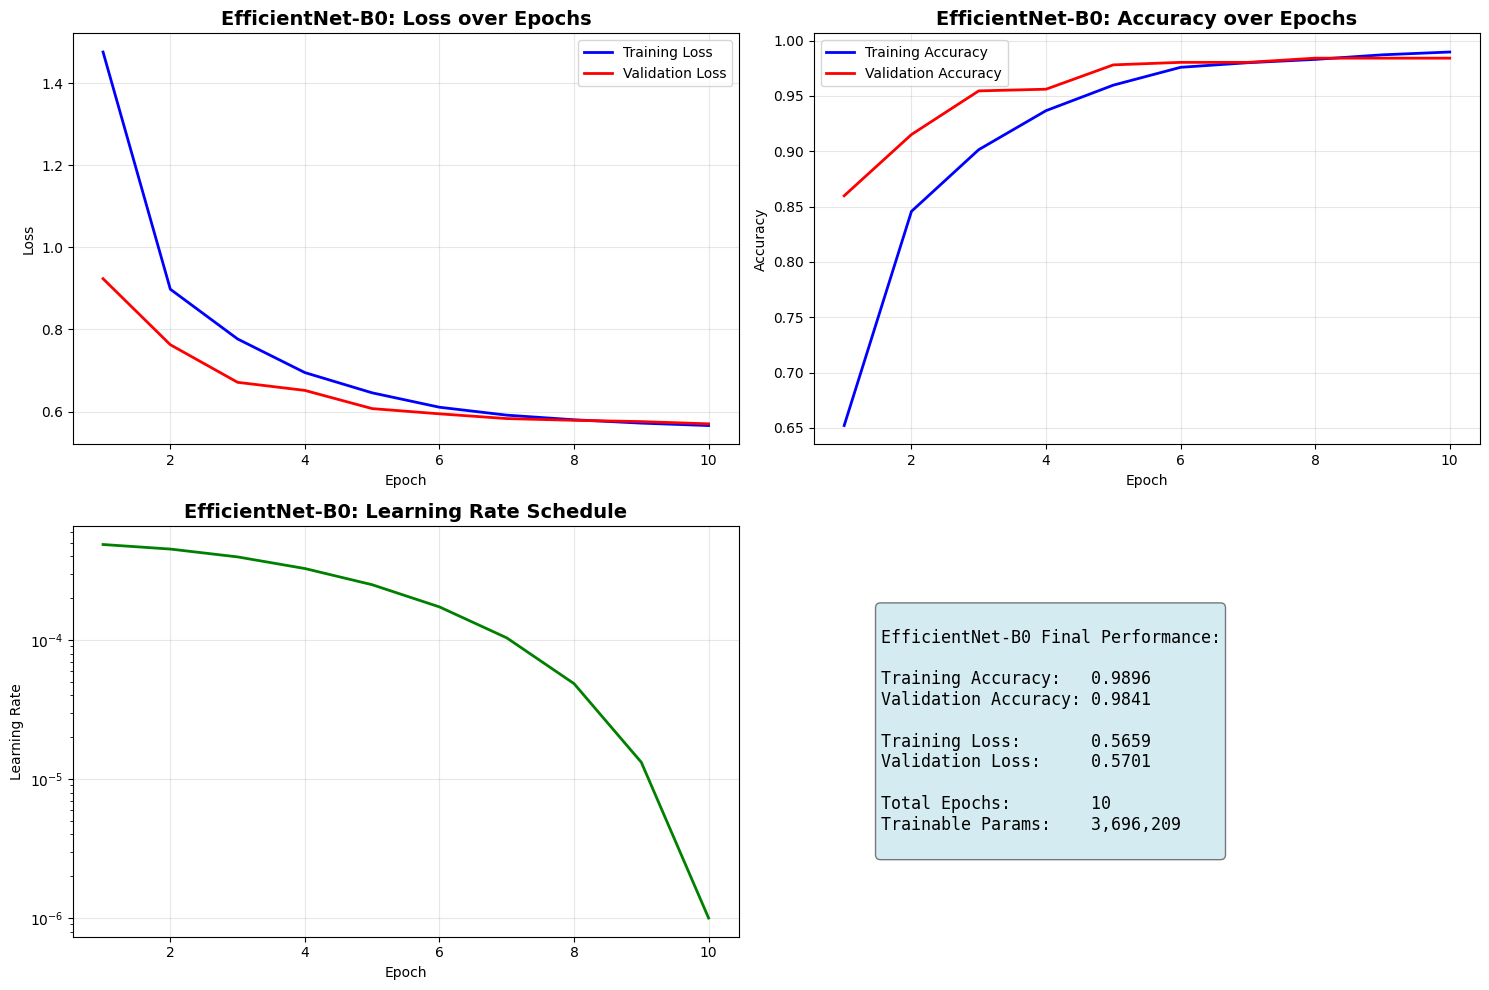

In [51]:
# Plot EfficientNet-B0 training results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs_eff = range(1, len(efficientnet_history['train_loss']) + 1)

# Training Loss
axes[0, 0].plot(epochs_eff, efficientnet_history['train_loss'], 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs_eff, efficientnet_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].set_title('EfficientNet-B0: Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Training Accuracy
axes[0, 1].plot(epochs_eff, efficientnet_history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
axes[0, 1].plot(epochs_eff, efficientnet_history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('EfficientNet-B0: Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning Rate
axes[1, 0].plot(epochs_eff, efficientnet_history['lr'], 'g-', linewidth=2)
axes[1, 0].set_title('EfficientNet-B0: Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Performance Summary
final_train_acc_eff = efficientnet_history['train_acc'][-1]
final_val_acc_eff = efficientnet_history['val_acc'][-1]
final_train_loss_eff = efficientnet_history['train_loss'][-1]
final_val_loss_eff = efficientnet_history['val_loss'][-1]

summary_text_eff = f"""
EfficientNet-B0 Final Performance:

Training Accuracy:   {final_train_acc_eff:.4f}
Validation Accuracy: {final_val_acc_eff:.4f}

Training Loss:       {final_train_loss_eff:.4f}
Validation Loss:     {final_val_loss_eff:.4f}

Total Epochs:        {len(epochs_eff)}
Trainable Params:    {trainable_params_eff:,}
"""

axes[1, 1].text(0.1, 0.5, summary_text_eff, fontsize=12, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(PART2_DIR, 'efficientnet_training_analysis.png'), dpi=300, bbox_inches='tight')
print(f"✓ EfficientNet-B0 training analysis saved to {PART2_DIR}/efficientnet_training_analysis.png")
plt.show()

## 22) Test: ResNet-50

test ResNet-50...
loss 0.5264 | acc 0.9910 (99.10%) | 1326/1338

report (ResNet-50):
                     precision    recall  f1-score   support

          Cardboard       1.00      1.00      1.00       130
      Food Organics       0.98      1.00      0.99       116
              Glass       0.99      0.99      0.99       115
              Metal       0.99      0.99      0.99       223
Miscellaneous Trash       0.97      0.99      0.98       138
              Paper       0.99      1.00      1.00       146
            Plastic       1.00      0.98      0.99       258
      Textile Trash       0.99      0.99      0.99        89
         Vegetation       1.00      0.98      0.99       123

           accuracy                           0.99      1338
          macro avg       0.99      0.99      0.99      1338
       weighted avg       0.99      0.99      0.99      1338

saved -> results\part2/resnet50_confusion_matrix.png


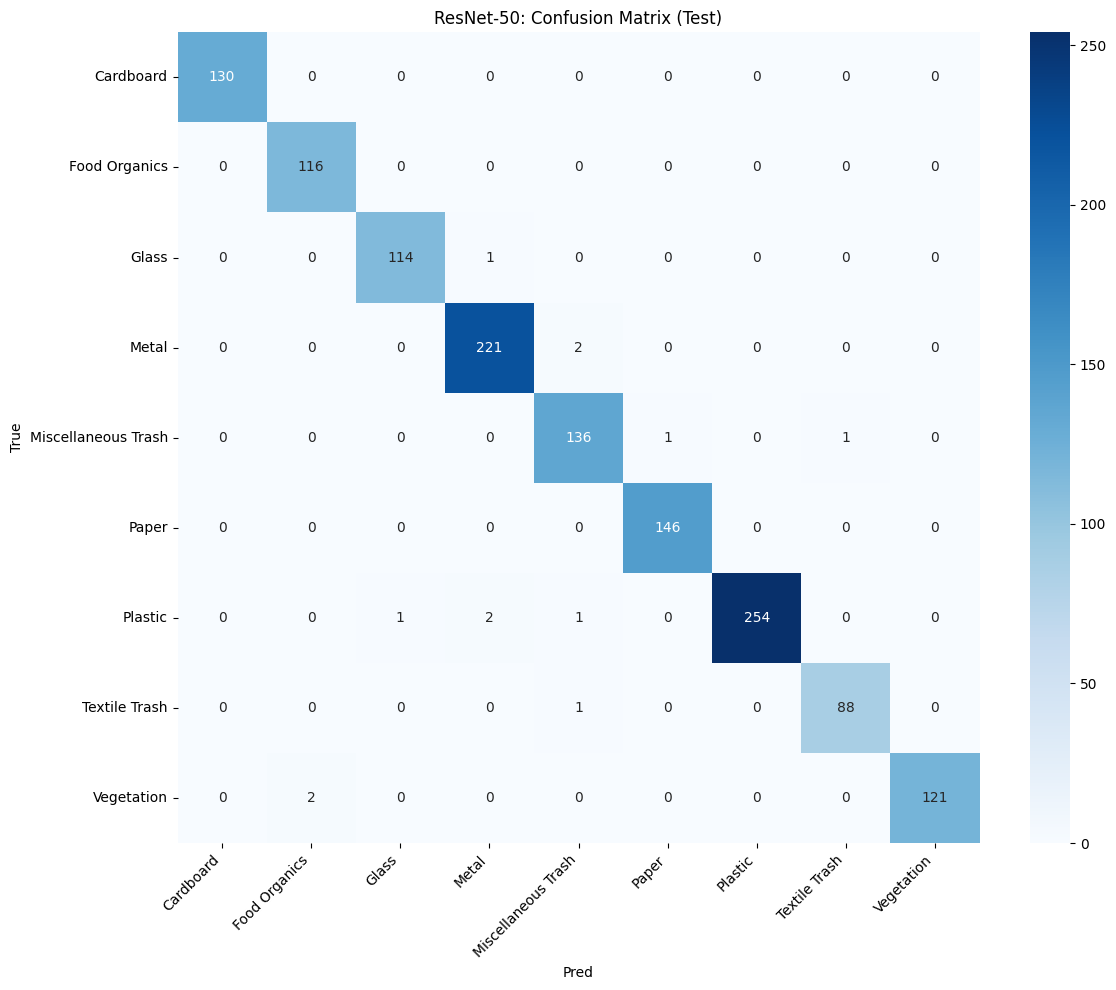

In [52]:
print("test ResNet-50...")

resnet50.eval()
all_preds_resnet, all_labels_resnet = [], []
test_loss_resnet, correct_resnet, total_resnet = 0.0, 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = resnet50(inputs)
        loss = criterion_resnet(outputs, labels)
        test_loss_resnet += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_resnet += labels.size(0)
        correct_resnet += (predicted == labels).sum().item()
        all_preds_resnet.extend(predicted.cpu().numpy())
        all_labels_resnet.extend(labels.cpu().numpy())

test_loss_resnet /= total_resnet
test_acc_resnet = correct_resnet / total_resnet
print(f"loss {test_loss_resnet:.4f} | acc {test_acc_resnet:.4f} ({test_acc_resnet*100:.2f}%) | {correct_resnet}/{total_resnet}")

print("\nreport (ResNet-50):")
print(classification_report(all_labels_resnet, all_preds_resnet, target_names=class_names))

cm_resnet = confusion_matrix(all_labels_resnet, all_preds_resnet)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet-50: Confusion Matrix (Test)')
plt.ylabel('True')
plt.xlabel('Pred')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(PART2_DIR, 'resnet50_confusion_matrix.png'), dpi=300, bbox_inches='tight')
print(f"saved -> {PART2_DIR}/resnet50_confusion_matrix.png")
plt.show()

## 23) Test: EfficientNet-B0

test EfficientNet-B0...
loss 0.5646 | acc 0.9851 (98.51%) | 1318/1338

report (EfficientNet-B0):
                     precision    recall  f1-score   support

          Cardboard       0.98      0.98      0.98       130
      Food Organics       0.99      0.99      0.99       116
              Glass       0.97      0.99      0.98       115
              Metal       0.99      0.98      0.98       223
Miscellaneous Trash       0.96      0.98      0.97       138
              Paper       0.99      0.98      0.98       146
            Plastic       0.99      0.98      0.99       258
      Textile Trash       0.98      0.99      0.98        89
         Vegetation       1.00      0.99      1.00       123

           accuracy                           0.99      1338
          macro avg       0.98      0.99      0.98      1338
       weighted avg       0.99      0.99      0.99      1338

saved -> results\part2/efficientnet_confusion_matrix.png


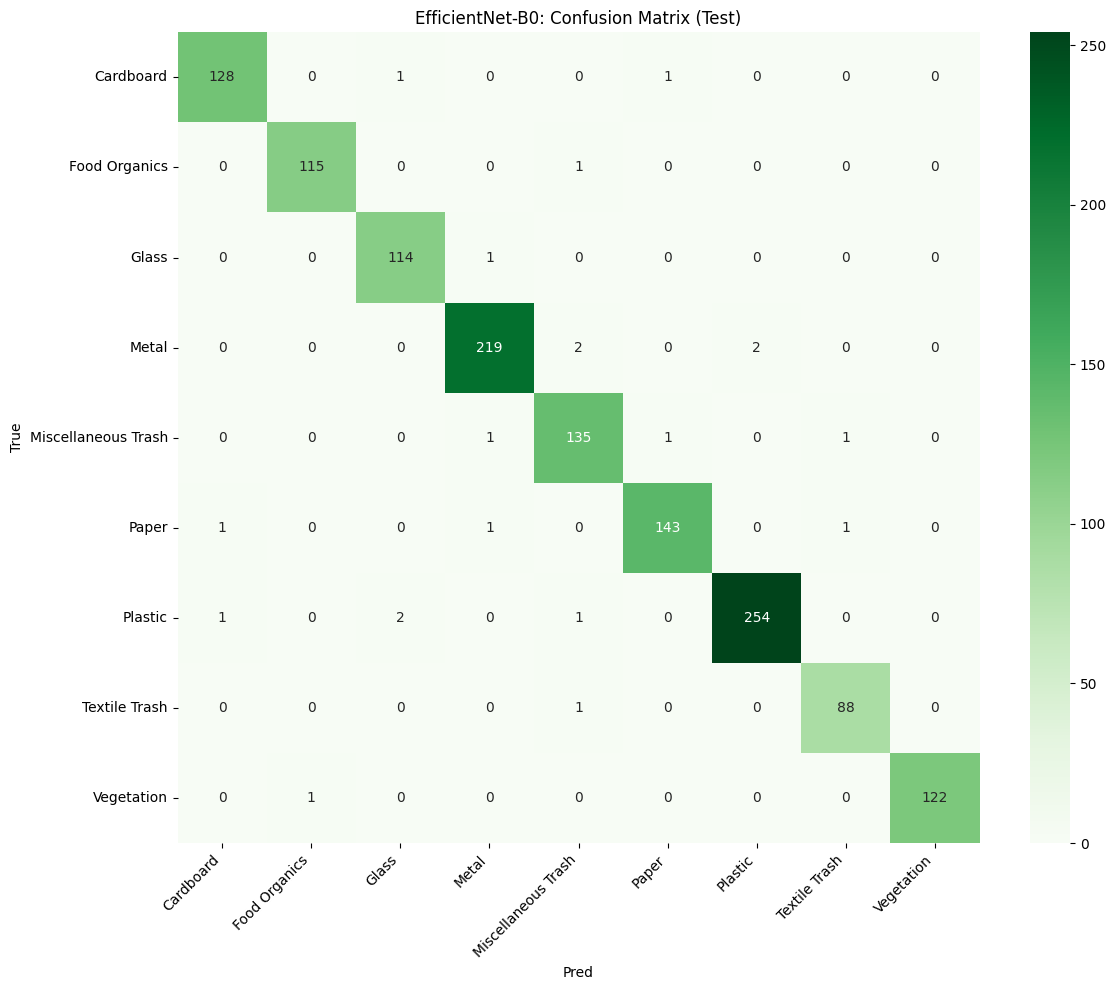

In [53]:
efficientnet_test_dataset = datasets.ImageFolder(
    root=os.path.join(SPLIT_DATA_DIR, 'test'),
    transform=efficientnet_val_transform
)

efficientnet_test_loader = DataLoader(
    efficientnet_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("test EfficientNet-B0...")

efficientnet_b0.eval()
all_preds_eff, all_labels_eff = [], []
test_loss_eff, correct_eff, total_eff = 0.0, 0, 0

with torch.no_grad():
    for inputs, labels in efficientnet_test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = efficientnet_b0(inputs)
        loss = criterion_eff(outputs, labels)
        test_loss_eff += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_eff += labels.size(0)
        correct_eff += (predicted == labels).sum().item()
        all_preds_eff.extend(predicted.cpu().numpy())
        all_labels_eff.extend(labels.cpu().numpy())

test_loss_eff /= total_eff
test_acc_eff = correct_eff / total_eff
print(f"loss {test_loss_eff:.4f} | acc {test_acc_eff:.4f} ({test_acc_eff*100:.2f}%) | {correct_eff}/{total_eff}")

print("\nreport (EfficientNet-B0):")
print(classification_report(all_labels_eff, all_preds_eff, target_names=class_names))

cm_eff = confusion_matrix(all_labels_eff, all_preds_eff)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('EfficientNet-B0: Confusion Matrix (Test)')
plt.ylabel('True')
plt.xlabel('Pred')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(PART2_DIR, 'efficientnet_confusion_matrix.png'), dpi=300, bbox_inches='tight')
print(f"saved -> {PART2_DIR}/efficientnet_confusion_matrix.png")
plt.show()

## 24) Compare models

✓ Comprehensive comparison saved to results\part2/all_models_comparison.png


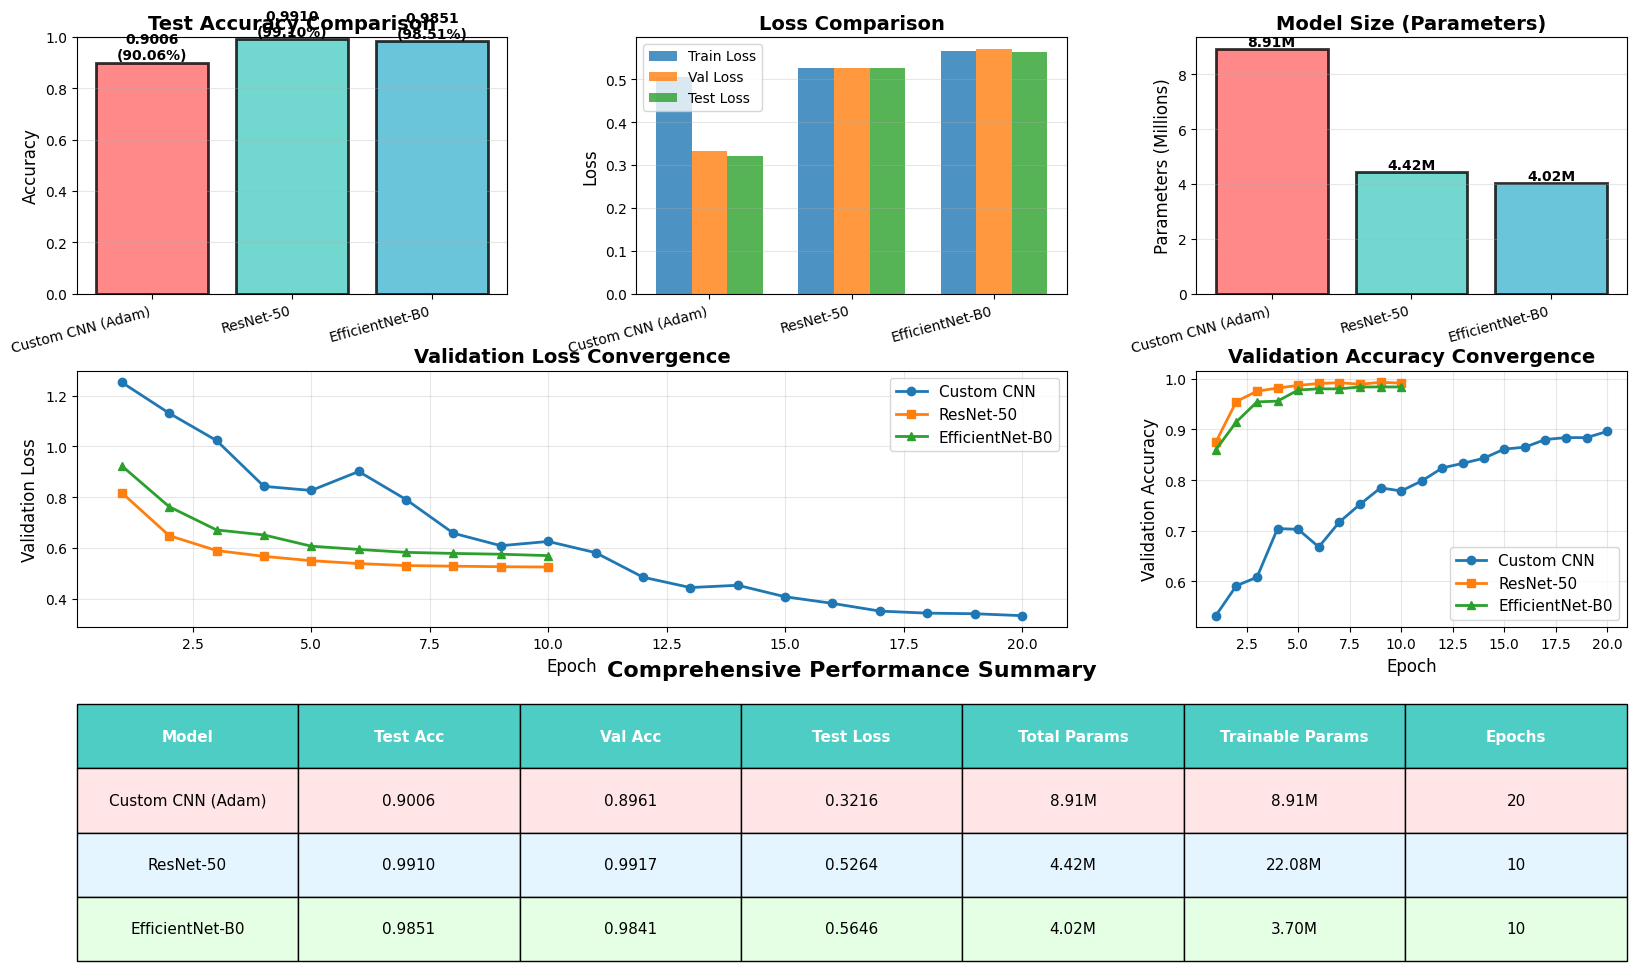


MODEL COMPARISON SUMMARY

Custom CNN (Adam):
  Test Accuracy:      0.9006 (90.06%)
  Validation Accuracy: 0.8961
  Test Loss:          0.3216
  Total Parameters:    8,913,161
  Training Epochs:     20

ResNet-50:
  Test Accuracy:      0.9910 (99.10%)
  Validation Accuracy: 0.9917
  Test Loss:          0.5264
  Total Parameters:    4,423,177
  Trainable Params:    22,081,545
  Training Epochs:     10

EfficientNet-B0:
  Test Accuracy:      0.9851 (98.51%)
  Validation Accuracy: 0.9841
  Test Loss:          0.5646
  Total Parameters:    4,019,077
  Trainable Params:    3,696,209
  Training Epochs:     10


In [54]:
# Collect all model results
models_comparison = {
    'Custom CNN (Adam)': {
        'train_acc': adam_history['train_acc'][-1],
        'val_acc': adam_history['val_acc'][-1],
        'test_acc': test_acc,
        'train_loss': adam_history['train_loss'][-1],
        'val_loss': adam_history['val_loss'][-1],
        'test_loss': test_loss,
        'params': sum(p.numel() for p in best_model.parameters()),
        'epochs': len(adam_history['train_acc'])
    },
    'ResNet-50': {
        'train_acc': resnet_history['train_acc'][-1],
        'val_acc': resnet_history['val_acc'][-1],
        'test_acc': test_acc_resnet,
        'train_loss': resnet_history['train_loss'][-1],
        'val_loss': resnet_history['val_loss'][-1],
        'test_loss': test_loss_resnet,
        'params': total_params,
        'trainable_params': trainable_params,
        'epochs': len(resnet_history['train_acc'])
    },
    'EfficientNet-B0': {
        'train_acc': efficientnet_history['train_acc'][-1],
        'val_acc': efficientnet_history['val_acc'][-1],
        'test_acc': test_acc_eff,
        'train_loss': efficientnet_history['train_loss'][-1],
        'val_loss': efficientnet_history['val_loss'][-1],
        'test_loss': test_loss_eff,
        'params': total_params_eff,
        'trainable_params': trainable_params_eff,
        'epochs': len(efficientnet_history['train_acc'])
    }
}

# Create comparison plots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Test Accuracy Comparison
ax1 = fig.add_subplot(gs[0, 0])
model_names = list(models_comparison.keys())
test_accs = [models_comparison[m]['test_acc'] for m in model_names]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax1.bar(model_names, test_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3, axis='y')
for i, (bar, acc) in enumerate(zip(bars, test_accs)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.4f}\n({acc*100:.2f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=15, ha='right')

# 2. Loss Comparison (Train, Val, Test)
ax2 = fig.add_subplot(gs[0, 1])
x = np.arange(len(model_names))
width = 0.25
train_losses = [models_comparison[m]['train_loss'] for m in model_names]
val_losses = [models_comparison[m]['val_loss'] for m in model_names]
test_losses = [models_comparison[m]['test_loss'] for m in model_names]

ax2.bar(x - width, train_losses, width, label='Train Loss', alpha=0.8)
ax2.bar(x, val_losses, width, label='Val Loss', alpha=0.8)
ax2.bar(x + width, test_losses, width, label='Test Loss', alpha=0.8)
ax2.set_title('Loss Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(model_names)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=15, ha='right')

# 3. Parameter Efficiency
ax3 = fig.add_subplot(gs[0, 2])
params_millions = [models_comparison[m]['params']/1e6 for m in model_names]
bars3 = ax3.bar(model_names, params_millions, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_title('Model Size (Parameters)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Parameters (Millions)', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')
for bar, param in zip(bars3, params_millions):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{param:.2f}M',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=15, ha='right')

# 4. Training Progress Comparison - Loss
ax4 = fig.add_subplot(gs[1, :2])
max_epochs = max([len(adam_history['train_loss']), 
                  len(resnet_history['train_loss']), 
                  len(efficientnet_history['train_loss'])])

ax4.plot(range(1, len(adam_history['val_loss'])+1), adam_history['val_loss'], 
         'o-', label='Custom CNN', linewidth=2, markersize=6)
ax4.plot(range(1, len(resnet_history['val_loss'])+1), resnet_history['val_loss'], 
         's-', label='ResNet-50', linewidth=2, markersize=6)
ax4.plot(range(1, len(efficientnet_history['val_loss'])+1), efficientnet_history['val_loss'], 
         '^-', label='EfficientNet-B0', linewidth=2, markersize=6)
ax4.set_title('Validation Loss Convergence', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Validation Loss', fontsize=12)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

# 5. Training Progress Comparison - Accuracy
ax5 = fig.add_subplot(gs[1, 2])
ax5.plot(range(1, len(adam_history['val_acc'])+1), adam_history['val_acc'], 
         'o-', label='Custom CNN', linewidth=2, markersize=6)
ax5.plot(range(1, len(resnet_history['val_acc'])+1), resnet_history['val_acc'], 
         's-', label='ResNet-50', linewidth=2, markersize=6)
ax5.plot(range(1, len(efficientnet_history['val_acc'])+1), efficientnet_history['val_acc'], 
         '^-', label='EfficientNet-B0', linewidth=2, markersize=6)
ax5.set_title('Validation Accuracy Convergence', fontsize=14, fontweight='bold')
ax5.set_xlabel('Epoch', fontsize=12)
ax5.set_ylabel('Validation Accuracy', fontsize=12)
ax5.legend(fontsize=11)
ax5.grid(True, alpha=0.3)

# 6. Performance Summary Table
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('tight')
ax6.axis('off')

summary_data = []
for model_name in model_names:
    data = models_comparison[model_name]
    row = [
        model_name,
        f"{data['test_acc']:.4f}",
        f"{data['val_acc']:.4f}",
        f"{data['test_loss']:.4f}",
        f"{data['params']/1e6:.2f}M",
        f"{data.get('trainable_params', data['params'])/1e6:.2f}M",
        f"{data['epochs']}"
    ]
    summary_data.append(row)

table = ax6.table(cellText=summary_data,
                  colLabels=['Model', 'Test Acc', 'Val Acc', 'Test Loss', 
                            'Total Params', 'Trainable Params', 'Epochs'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style the header
for i in range(7):
    table[(0, i)].set_facecolor('#4ECDC4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color code rows
for i in range(1, 4):
    for j in range(7):
        if i == 1:
            table[(i, j)].set_facecolor('#FFE5E5')
        elif i == 2:
            table[(i, j)].set_facecolor('#E5F5FF')
        else:
            table[(i, j)].set_facecolor('#E5FFE5')

ax6.set_title('Comprehensive Performance Summary', fontsize=16, fontweight='bold', pad=20)

plt.savefig(os.path.join(PART2_DIR, 'all_models_comparison.png'), dpi=300, bbox_inches='tight')
print(f"✓ Comprehensive comparison saved to {PART2_DIR}/all_models_comparison.png")
plt.show()

# Print summary
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
for model_name in model_names:
    data = models_comparison[model_name]
    print(f"\n{model_name}:")
    print(f"  Test Accuracy:      {data['test_acc']:.4f} ({data['test_acc']*100:.2f}%)")
    print(f"  Validation Accuracy: {data['val_acc']:.4f}")
    print(f"  Test Loss:          {data['test_loss']:.4f}")
    print(f"  Total Parameters:    {data['params']:,}")
    if 'trainable_params' in data:
        print(f"  Trainable Params:    {data['trainable_params']:,}")
    print(f"  Training Epochs:     {data['epochs']}")
print("="*80)

## Discussion: Trade-offs, Advantages, and Limitations

Based on our comprehensive experiments and analysis, let's discuss the key findings and insights from comparing the custom CNN with state-of-the-art pre-trained models.

### Confusion matrices

saved -> results\part2/all_confusion_matrices_comparison.png


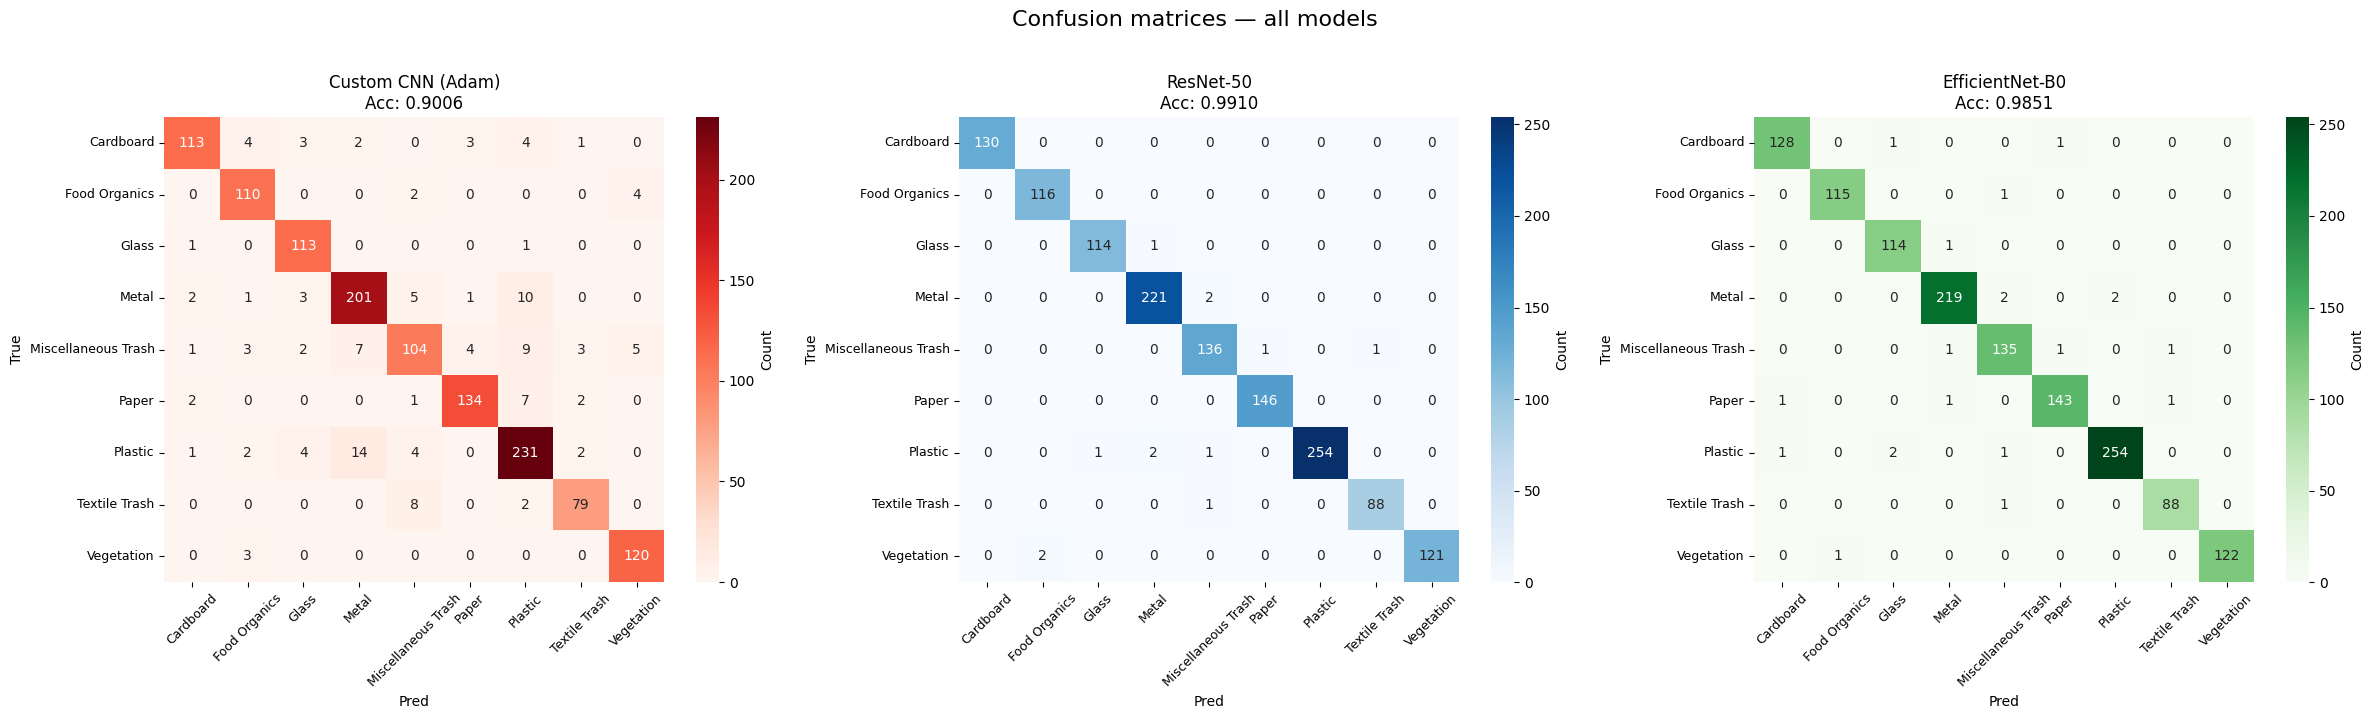

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})
axes[0].set_title(f'Custom CNN (Adam)\nAcc: {test_acc:.4f}')
axes[0].set_ylabel('True'); axes[0].set_xlabel('Pred')
axes[0].tick_params(axis='x', rotation=45, labelsize=9)
axes[0].tick_params(axis='y', rotation=0, labelsize=9)

sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})
axes[1].set_title(f'ResNet-50\nAcc: {test_acc_resnet:.4f}')
axes[1].set_ylabel('True'); axes[1].set_xlabel('Pred')
axes[1].tick_params(axis='x', rotation=45, labelsize=9)
axes[1].tick_params(axis='y', rotation=0, labelsize=9)

sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})
axes[2].set_title(f'EfficientNet-B0\nAcc: {test_acc_eff:.4f}')
axes[2].set_ylabel('True'); axes[2].set_xlabel('Pred')
axes[2].tick_params(axis='x', rotation=45, labelsize=9)
axes[2].tick_params(axis='y', rotation=0, labelsize=9)

plt.suptitle('Confusion matrices — all models', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(PART2_DIR, 'all_confusion_matrices_comparison.png'), dpi=300, bbox_inches='tight')
print(f"saved -> {PART2_DIR}/all_confusion_matrices_comparison.png")
plt.show()

